In [5]:
# Installs all the necessary packages for the project
# %pip install pandas pandas-ta numpy matplotlib statsmodels pandas_datareader datetime yfinance scikit-learn PyPortfolioOpt
# %pip install --upgrade certifi

In [6]:
# Imports all the necessary packages for the project and fixes ssl error
import ssl
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta as ta
import warnings
warnings.filterwarnings('ignore')
ssl._create_default_https_context = ssl._create_unverified_context

In [7]:
# Get SP500 data    
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

end_date = dt.datetime.now().strftime('%Y-%m-%d')
start_date = (pd.to_datetime(end_date) - pd.DateOffset(years=10)).strftime('%Y-%m-%d')

df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()

df.index.names = ['Date', 'Symbol']

df

[*********************100%%**********************]  503 of 503 completed


Adj Close       Close        High         Low        Open  \
Date       Symbol                                                               
2014-02-03 A        36.894333   40.164520   41.831188   40.114449   41.595135   
           AAL      32.015495   33.959999   34.480000   33.049999   33.950001   
           AAPL     15.703117   17.911785   18.133215   17.832144   17.950357   
           ABBV     31.383663   47.349998   49.490002   47.060001   49.400002   
           ABT      29.580915   35.849998   36.950001   35.799999   36.580002   
...                       ...         ...         ...         ...         ...   
2024-02-02 YUM     128.750000  128.750000  130.039993  127.690002  129.639999   
           ZBH     126.320000  126.320000  127.400002  125.599998  126.910004   
           ZBRA    246.479996  246.479996  247.940002  237.059998  240.210007   
           ZION     39.650002   39.650002   39.810001   37.959999   38.099998   
           ZTS     189.039993  189.039993  190.179993  185.619995  187.389999   

                        Volume  
Date       Symbol               
2014-02-03 A         4095161.0  
           AAL      21739500.0  
           AAPL    401464000.0  
           ABBV     10314600.0  
           ABT      12231900.0  
...                        ...  
2024-02-02 YUM       1823800.0  
           ZBH       1058500.0  
           ZBRA       418600.0  
           ZION      6329600.0  
           ZTS       1177700.0  

[1236452 rows x 6 columns]

In [8]:
# Calculate features and technical indicators
# Garman-Klass Volatility, RSI, Bollinger Bands, ATR, MACD, Dollar Volume,
# All but RSI are normalized by subtracting the mean and dividing by the standard deviation

df['Garman-Klass'] = ((np.log(df['High'])-np.log(df['Low']))**2)/2-(2*np.log(2)-1)*((np.log(df['Adj Close'])-np.log(df['Open']))**2)  

df['RSI'] = df.groupby(level=1)['Adj Close'].transform(lambda x: ta.rsi(close=x, length=20))

df['BB-Low'] = df.groupby(level=1)['Adj Close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['BB-Mid'] = df.groupby(level=1)['Adj Close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['BB-High'] = df.groupby(level=1)['Adj Close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(data):
    atr = ta.atr(high=data['High'],
                        low=data['Low'],
                        close=data['Close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())
df['ATR'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['MACD'] = df.groupby(level=1, group_keys=False)['Adj Close'].apply(compute_macd)

df['Dollar Volume'] = (df['Adj Close']*df['Volume'])/1e6

df


Adj Close       Close        High         Low        Open  \
Date       Symbol                                                               
2014-02-03 A        36.894333   40.164520   41.831188   40.114449   41.595135   
           AAL      32.015495   33.959999   34.480000   33.049999   33.950001   
           AAPL     15.703117   17.911785   18.133215   17.832144   17.950357   
           ABBV     31.383663   47.349998   49.490002   47.060001   49.400002   
           ABT      29.580915   35.849998   36.950001   35.799999   36.580002   
...                       ...         ...         ...         ...         ...   
2024-02-02 YUM     128.750000  128.750000  130.039993  127.690002  129.639999   
           ZBH     126.320000  126.320000  127.400002  125.599998  126.910004   
           ZBRA    246.479996  246.479996  247.940002  237.059998  240.210007   
           ZION     39.650002   39.650002   39.810001   37.959999   38.099998   
           ZTS     189.039993  189.039993  190.179993  185.619995  187.389999   

                        Volume  Garman-Klass        RSI    BB-Low    BB-Mid  \
Date       Symbol                                                             
2014-02-03 A         4095161.0     -0.004678        NaN       NaN       NaN   
           AAL      21739500.0     -0.000433        NaN       NaN       NaN   
           AAPL    401464000.0     -0.006770        NaN       NaN       NaN   
           ABBV     10314600.0     -0.078236        NaN       NaN       NaN   
           ABT      12231900.0     -0.016923        NaN       NaN       NaN   
...                        ...           ...        ...       ...       ...   
2024-02-02 YUM       1823800.0      0.000148  49.062312  4.856886  4.873482   
           ZBH       1058500.0      0.000093  64.934995  4.790665  4.818914   
           ZBRA       418600.0      0.000750  48.173277  5.481656  5.529192   
           ZION      6329600.0      0.000518  44.684089  3.699349  3.777674   
           ZTS       1177700.0      0.000265  49.434320  5.224122  5.261216   

                    BB-High       ATR      MACD  Dollar Volume  
Date       Symbol                                               
2014-02-03 A            NaN       NaN       NaN     151.088233  
           AAL          NaN       NaN       NaN     696.000860  
           AAPL         NaN       NaN       NaN    6304.236312  
           ABBV         NaN       NaN       NaN     323.709932  
           ABT          NaN       NaN       NaN     361.830800  
...                     ...       ...       ...            ...  
2024-02-02 YUM     4.890078  0.417506  0.048180     234.814250  
           ZBH     4.847164 -0.340355  0.680013     133.709720  
           ZBRA    5.576728  0.377059 -0.299587     103.176526  
           ZION    3.856000  1.079380 -0.074163     250.968650  
           ZTS     5.298310  0.990356 -0.434109     222.632400  

[1236452 rows x 14 columns]

In [9]:
# Aggregate to monthly data and filter top 150 most liquid stocks for each month

tech_cols = [c for c in df.columns.unique(0) if c not in ['Dollar Volume', 'Volume', 'Open',
                                                          'High', 'Low', 'Close']]

tech_data = (pd.concat([df.unstack('Symbol')['Dollar Volume'].resample('M').mean().stack('Symbol').to_frame('Dollar Volume'),
                   df.unstack()[tech_cols].resample('M').last().stack('Symbol')],
                  axis=1)).dropna()

# Calculate 5-year rolling average of Dollar Volume
tech_data['Dollar Volume'] = (tech_data.loc[:, 'Dollar Volume'].unstack('Symbol').rolling(5*12, min_periods=12).mean().stack())

tech_data['DV Rank'] = (tech_data.groupby('Date')['Dollar Volume'].rank(ascending=False))

# Filter top 150 most liquid stocks for each month and put in new dataframe
#tech_data = tech_data[tech_data['DV Rank']<150].drop(['Dollar Volume', 'DV Rank'], axis=1)
top_150 = tech_data[tech_data['DV Rank'] < 150]

top_150


Dollar Volume   Adj Close  Garman-Klass        RSI  \
Date       Symbol                                                       
2015-02-28 AAL        489.261942   45.477367     -0.001642  45.417062   
           AAPL      5126.441599   28.860926     -0.005285  62.555867   
           ABBV       371.581296   41.377701     -0.055845  48.492216   
           ABT        195.715541   39.949802     -0.011462  61.637932   
           ACN        189.507277   77.266296     -0.009006  55.963577   
...                          ...         ...           ...        ...   
2024-02-29 VRTX       402.343672  424.679993      0.000073  55.479647   
           VZ         795.746247   42.130001      0.000114  66.047980   
           WFC        992.047998   49.160000      0.000408  56.285441   
           WMT        983.264585  169.570007      0.000096  68.719276   
           XOM       1437.522456  101.970001      0.000155  51.749501   

                     BB-Low    BB-Mid   BB-High       ATR      MACD  DV Rank  
Date       Symbol                                                             
2015-02-28 AAL     3.807215  3.858552  3.909889  1.977006 -0.192171     35.0  
           AAPL    3.289049  3.368803  3.448558 -0.780710  0.276328      1.0  
           ABBV    3.660831  3.721655  3.782480 -0.702456 -0.424982     51.0  
           ABT     3.641809  3.685499  3.729188 -0.909714  0.366691    116.0  
           ACN     4.306900  4.345959  4.385019 -0.968092 -0.045104    120.0  
...                     ...       ...       ...       ...       ...      ...  
2024-02-29 VRTX    6.035105  6.068799  6.102493  1.473376  1.940126    114.0  
           VZ      3.646189  3.724029  3.801870  0.149058  2.779353     45.0  
           WFC     3.853271  3.905167  3.957063  0.089445  0.703446     33.0  
           WMT     5.060651  5.097581  5.134510  0.370942  1.694694     34.0  
           XOM     4.567458  4.616580  4.665701  0.436121  0.328423     16.0  

[16241 rows x 10 columns]

In [10]:
# Calculate monthly returns for different time horizons on the top 150 most liquid stocks
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags:
        df[f'{lag}m Return'] = (df['Adj Close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df

returns = top_150.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
returns

Dollar Volume   Adj Close  Garman-Klass        RSI  \
Date       Symbol                                                       
2016-02-29 AAL        479.985131   39.288372     -0.000319  54.607038   
           AAPL      5210.567751   22.125885     -0.003013  46.730950   
           ABBV       404.930425   38.690907     -0.051766  48.010313   
           ABT        216.240057   33.398457     -0.009964  46.271647   
           ACN        209.341640   87.900650     -0.006994  49.785707   
...                          ...         ...           ...        ...   
2024-02-29 VRTX       402.343672  424.679993      0.000073  55.479647   
           VZ         795.746247   42.130001      0.000114  66.047980   
           WFC        992.047998   49.160000      0.000408  56.285441   
           WMT        983.264585  169.570007      0.000096  68.719276   
           XOM       1437.522456  101.970001      0.000155  51.749501   

                     BB-Low    BB-Mid   BB-High       ATR      MACD  DV Rank  \
Date       Symbol                                                              
2016-02-29 AAL     3.547833  3.638645  3.729458  0.678113  0.538953     39.0   
           AAPL    3.106253  3.130723  3.155194 -0.832709 -0.352232      1.0   
           ABBV    3.629341  3.677365  3.725388 -0.335010 -0.287152     49.0   
           ABT     3.479070  3.522661  3.566251 -0.588495 -0.393035    113.0   
           ACN     4.405535  4.474354  4.543174 -0.607943 -0.299895    121.0   
...                     ...       ...       ...       ...       ...      ...   
2024-02-29 VRTX    6.035105  6.068799  6.102493  1.473376  1.940126    114.0   
           VZ      3.646189  3.724029  3.801870  0.149058  2.779353     45.0   
           WFC     3.853271  3.905167  3.957063  0.089445  0.703446     33.0   
           WMT     5.060651  5.097581  5.134510  0.370942  1.694694     34.0   
           XOM     4.567458  4.616580  4.665701  0.436121  0.328423     16.0   

                   1m Return  2m Return  3m Return  6m Return  9m Return  \
Date       Symbol                                                          
2016-02-29 AAL      0.054421  -0.014726  -0.001198   0.009276  -0.002847   
           AAPL    -0.001288  -0.038976  -0.063339  -0.023726  -0.031060   
           ABBV    -0.005283  -0.034844  -0.017302  -0.018800  -0.018854   
           ABT      0.023514  -0.068304  -0.046141  -0.023736  -0.023047   
           ACN     -0.050028  -0.020497  -0.022124   0.012121   0.005983   
...                      ...        ...        ...        ...        ...   
2024-02-29 VRTX    -0.020075   0.021627   0.061749   0.033578   0.030674   
           VZ      -0.005195   0.065998   0.037779   0.038009   0.025105   
           WFC     -0.013446   0.002894   0.035471   0.032231   0.026413   
           WMT      0.026142   0.037116   0.030148   0.007632   0.016916   
           XOM     -0.008170   0.009903  -0.002504  -0.012827   0.001691   

                   12m Return  
Date       Symbol              
2016-02-29 AAL      -0.012117  
           AAPL     -0.021902  
           ABBV     -0.005579  
           ABT      -0.014815  
           ACN       0.010804  
...                       ...  
2024-02-29 VRTX      0.032213  
           VZ        0.012923  
           WFC       0.006798  
           WMT       0.016100  
           XOM      -0.004081  

[13946 rows x 16 columns]

In [11]:
# Use Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=start_date, end=end_date)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data.index.name = 'Date'
factor_data = factor_data.resample('M').last().div(100)
factor_data = factor_data.join(returns['1m Return']).sort_index()


# Filter out stocks with less than 10 months of data.
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
factor_data = factor_data[factor_data.index.get_level_values('Symbol').isin(valid_stocks.index)]

factor_data


Mkt-RF     SMB     HML     RMW     CMA  1m Return
Date       Symbol                                                   
2016-02-29 AAL    -0.0007  0.0088 -0.0057  0.0325  0.0202   0.054421
           AAPL   -0.0007  0.0088 -0.0057  0.0325  0.0202  -0.001288
           ABBV   -0.0007  0.0088 -0.0057  0.0325  0.0202  -0.005283
           ABT    -0.0007  0.0088 -0.0057  0.0325  0.0202   0.023514
           ACN    -0.0007  0.0088 -0.0057  0.0325  0.0202  -0.050028
...                   ...     ...     ...     ...     ...        ...
2023-12-31 VRTX    0.0485  0.0732  0.0494 -0.0307  0.0132   0.146783
           VZ      0.0485  0.0732  0.0494 -0.0307  0.0132  -0.016436
           WFC     0.0485  0.0732  0.0494 -0.0307  0.0132   0.103835
           WMT     0.0485  0.0732  0.0494 -0.0307  0.0132   0.016350
           XOM     0.0485  0.0732  0.0494 -0.0307  0.0132  -0.026864

[13626 rows x 6 columns]

In [12]:
# Calculate Rolling Factor Betas

betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['1m Return'], 
                                     exog=sm.add_constant(x.drop('1m Return', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

#betas 

# Join betas to returns dataframe
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data = (returns.join(betas.groupby('Symbol').shift()))
data.loc[:, factors] = data.groupby('Symbol', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
#data = data.drop(['Adj Close', 'Dollar Volume', 'DV Rank', axis=1)
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13680 entries, (Timestamp('2016-02-29 00:00:00'), 'AAL') to (Timestamp('2024-02-29 00:00:00'), 'XOM')
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dollar Volume  13680 non-null  float64
 1   Adj Close      13680 non-null  float64
 2   Garman-Klass   13680 non-null  float64
 3   RSI            13680 non-null  float64
 4   BB-Low         13680 non-null  float64
 5   BB-Mid         13680 non-null  float64
 6   BB-High        13680 non-null  float64
 7   ATR            13680 non-null  float64
 8   MACD           13680 non-null  float64
 9   DV Rank        13680 non-null  float64
 10  1m Return      13680 non-null  float64
 11  2m Return      13680 non-null  float64
 12  3m Return      13680 non-null  float64
 13  6m Return      13680 non-null  float64
 14  9m Return      13680 non-null  float64
 15  12m Return     13680 non-null  float64
 16  Mkt-RF         136

In [14]:
# K-Means Clustering for each month
from sklearn.cluster import KMeans
# N Clusters = 4
# Define initial centroids

target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values), 21))
initial_centroids[:, 6] = target_rsi_values


def get_clusters(df):
    df['Cluster'] = KMeans(n_clusters=4,
                           #random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('Date', group_keys=False).apply(get_clusters)

data


Dollar Volume   Adj Close  Garman-Klass        RSI  \
Date       Symbol                                                       
2016-02-29 AAL        479.985131   39.288372     -0.000319  54.607038   
           AAPL      5210.567751   22.125885     -0.003013  46.730950   
           ABBV       404.930425   38.690907     -0.051766  48.010313   
           ABT        216.240057   33.398457     -0.009964  46.271647   
           ACN        209.341640   87.900650     -0.006994  49.785707   
...                          ...         ...           ...        ...   
2024-02-29 VRTX       402.343672  424.679993      0.000073  55.479647   
           VZ         795.746247   42.130001      0.000114  66.047980   
           WFC        992.047998   49.160000      0.000408  56.285441   
           WMT        983.264585  169.570007      0.000096  68.719276   
           XOM       1437.522456  101.970001      0.000155  51.749501   

                     BB-Low    BB-Mid   BB-High       ATR      MACD  DV Rank  \
Date       Symbol                                                              
2016-02-29 AAL     3.547833  3.638645  3.729458  0.678113  0.538953     39.0   
           AAPL    3.106253  3.130723  3.155194 -0.832709 -0.352232      1.0   
           ABBV    3.629341  3.677365  3.725388 -0.335010 -0.287152     49.0   
           ABT     3.479070  3.522661  3.566251 -0.588495 -0.393035    113.0   
           ACN     4.405535  4.474354  4.543174 -0.607943 -0.299895    121.0   
...                     ...       ...       ...       ...       ...      ...   
2024-02-29 VRTX    6.035105  6.068799  6.102493  1.473376  1.940126    114.0   
           VZ      3.646189  3.724029  3.801870  0.149058  2.779353     45.0   
           WFC     3.853271  3.905167  3.957063  0.089445  0.703446     33.0   
           WMT     5.060651  5.097581  5.134510  0.370942  1.694694     34.0   
           XOM     4.567458  4.616580  4.665701  0.436121  0.328423     16.0   

                   ...  3m Return  6m Return  9m Return  12m Return    Mkt-RF  \
Date       Symbol  ...                                                          
2016-02-29 AAL     ...  -0.001198   0.009276  -0.002847   -0.012117  1.339013   
           AAPL    ...  -0.063339  -0.023726  -0.031060   -0.021902  1.063758   
           ABBV    ...  -0.017302  -0.018800  -0.018854   -0.005579  0.760760   
           ABT     ...  -0.046141  -0.023736  -0.023047   -0.014815  0.928559   
           ACN     ...  -0.022124   0.012121   0.005983    0.010804  1.149445   
...                ...        ...        ...        ...         ...       ...   
2024-02-29 VRTX    ...   0.061749   0.033578   0.030674    0.032213  0.835021   
           VZ      ...   0.037779   0.038009   0.025105    0.012923  0.613320   
           WFC     ...   0.035471   0.032231   0.026413    0.006798  1.216008   
           WMT     ...   0.030148   0.007632   0.016916    0.016100  0.785562   
           XOM     ...  -0.002504  -0.012827   0.001691   -0.004081  1.131857   

                        SMB       HML       RMW       CMA  Cluster  
Date       Symbol                                                   
2016-02-29 AAL     1.049797  0.686416  0.757929  0.245649        0  
           AAPL   -0.186390 -0.510756  0.573833 -0.430680        1  
           ABBV    0.218721  0.084090 -0.202207 -0.081657        0  
           ABT    -0.192275 -0.536357  0.087645  0.753452        0  
           ACN    -0.148291 -0.260759  0.185507 -0.016462        0  
...                     ...       ...       ...       ...      ...  
2024-02-29 VRTX    0.048155 -1.325341 -0.075977  0.966120        0  
           VZ     -0.370552 -0.041573  0.356599  0.951291        0  
           WFC    -0.138476  1.272489 -0.671139 -0.202210        0  
           WMT    -0.504783 -0.213150  0.601753  0.643465        0  
           XOM     0.270071  0.351504 -0.437973  0.902578        0  

[13680 rows x 22 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


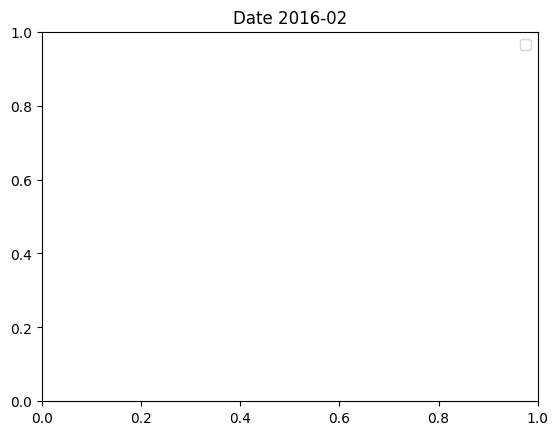

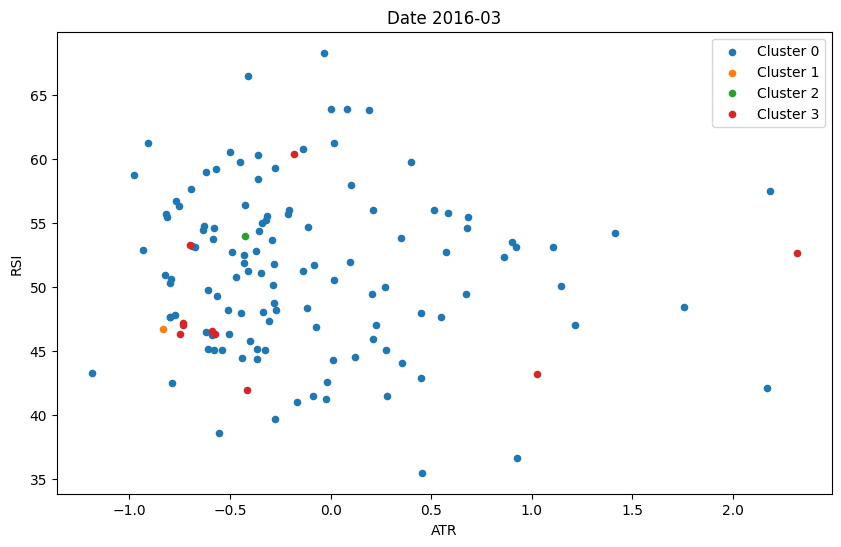

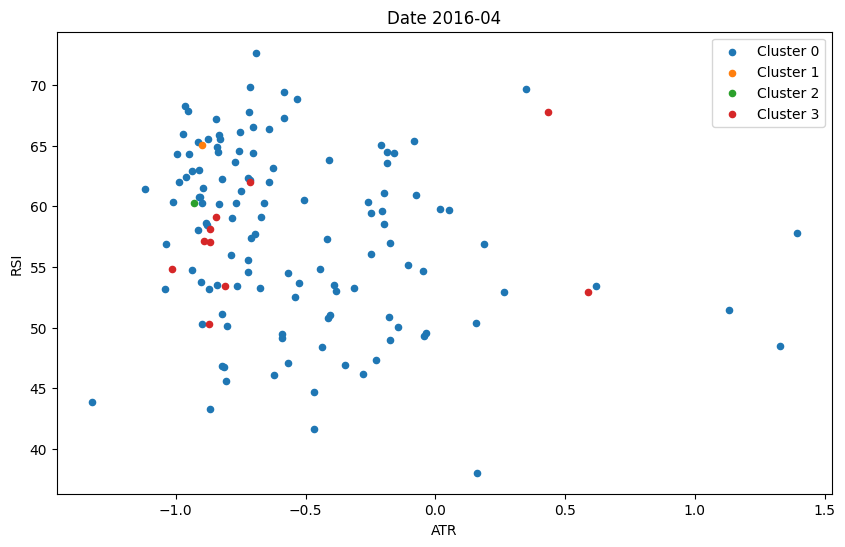

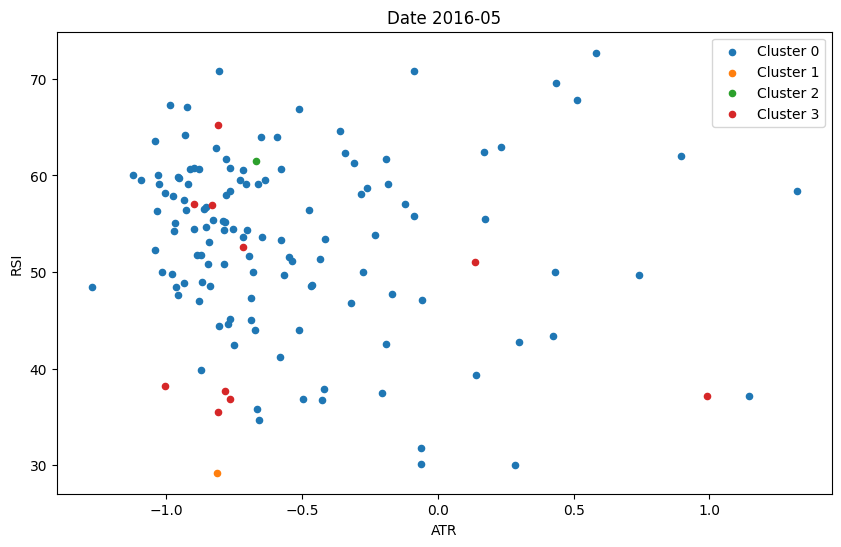

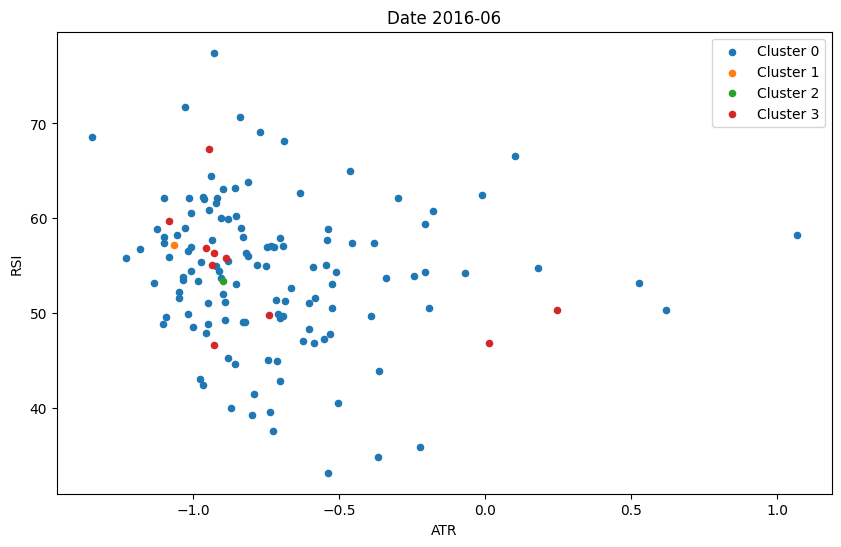

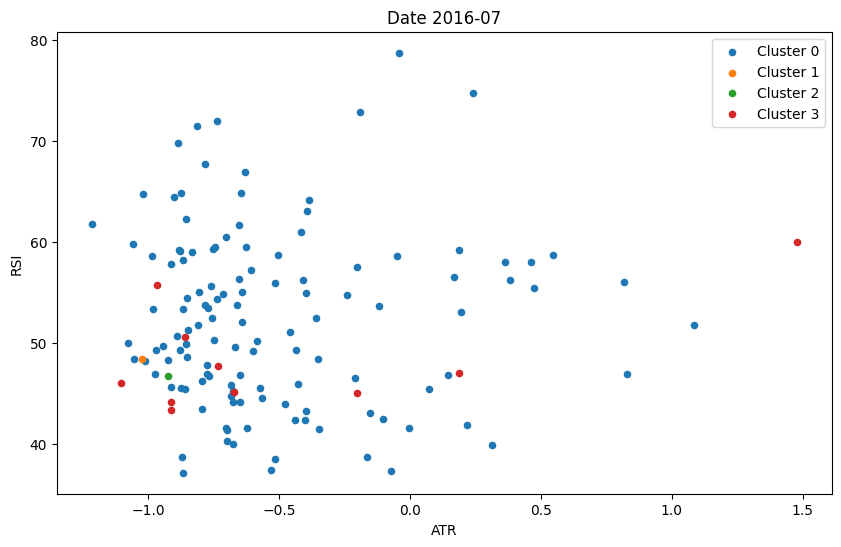

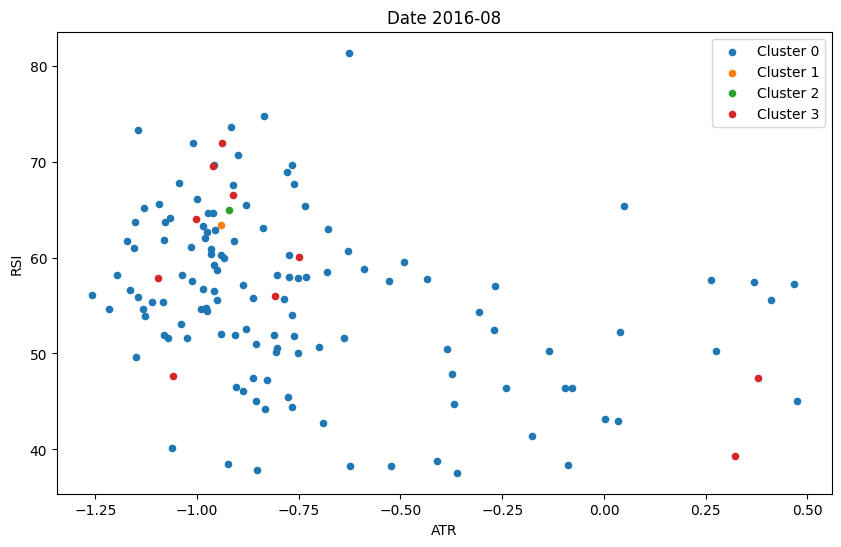

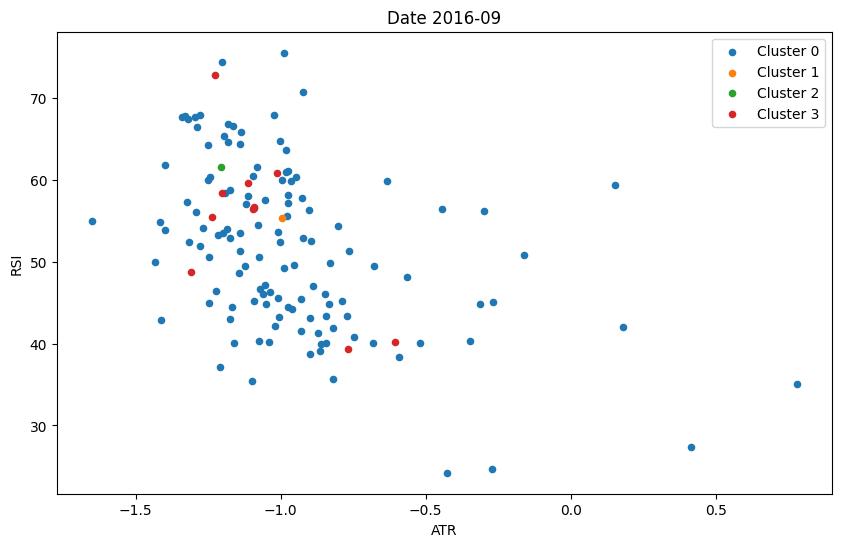

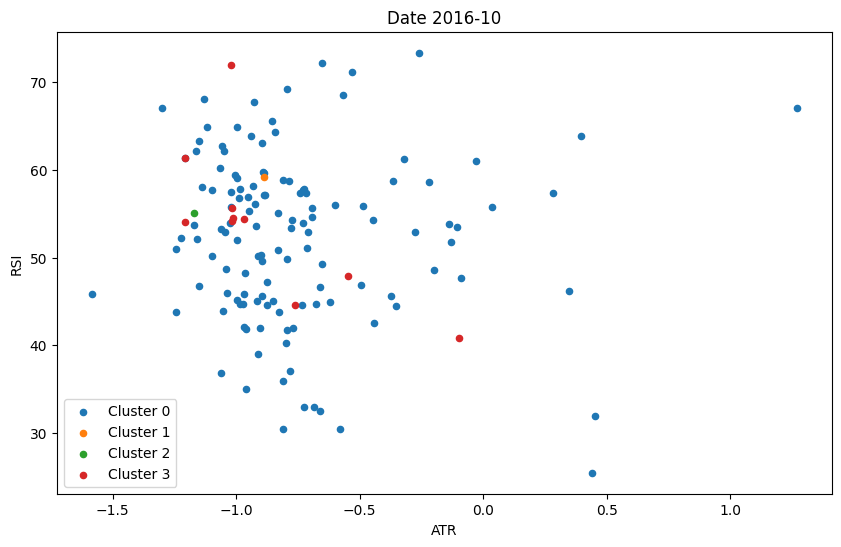

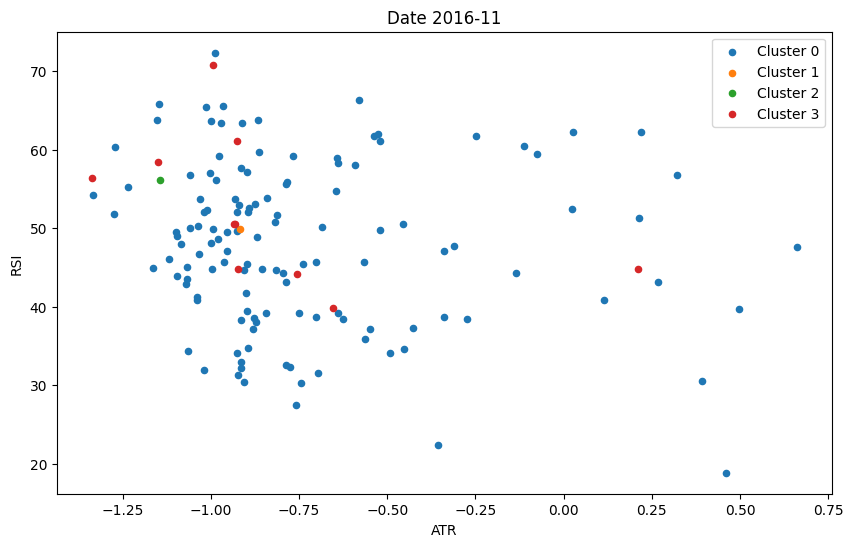

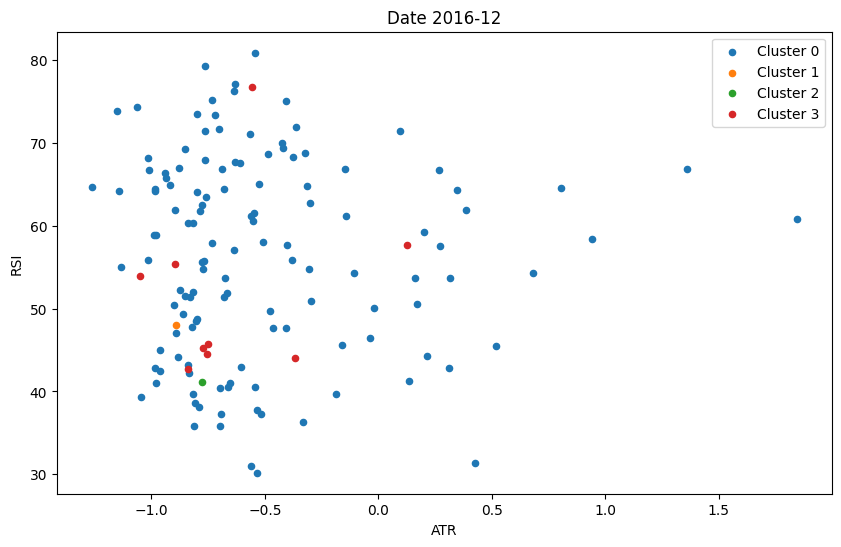

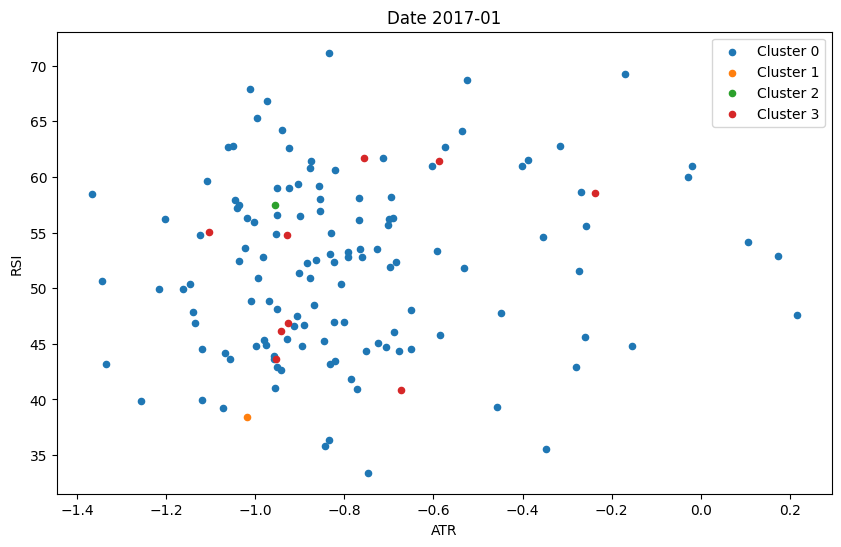

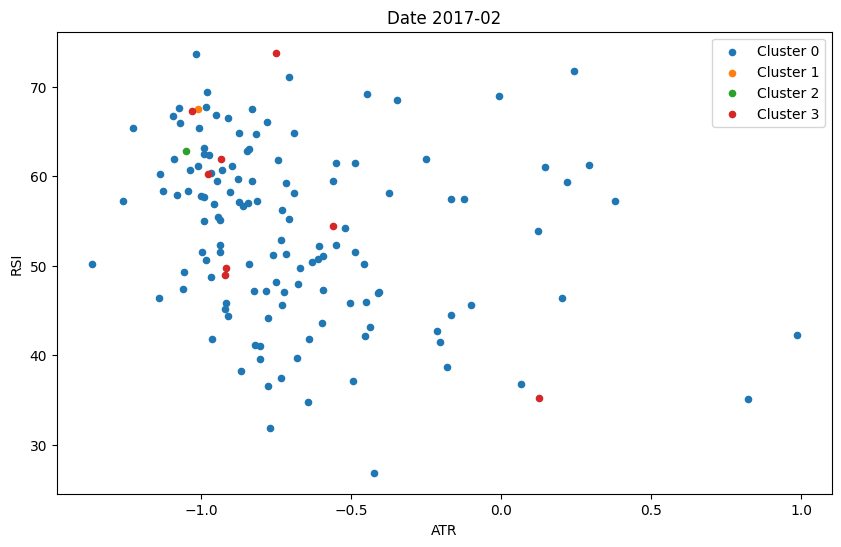

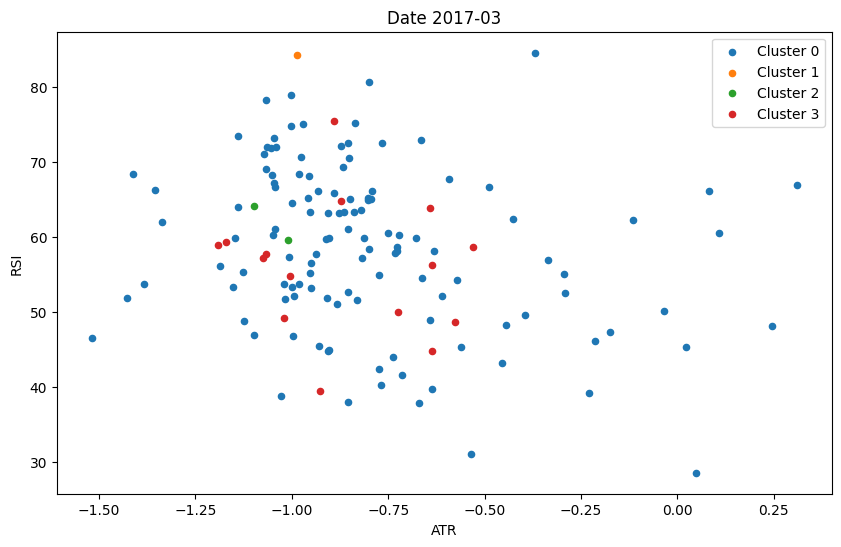

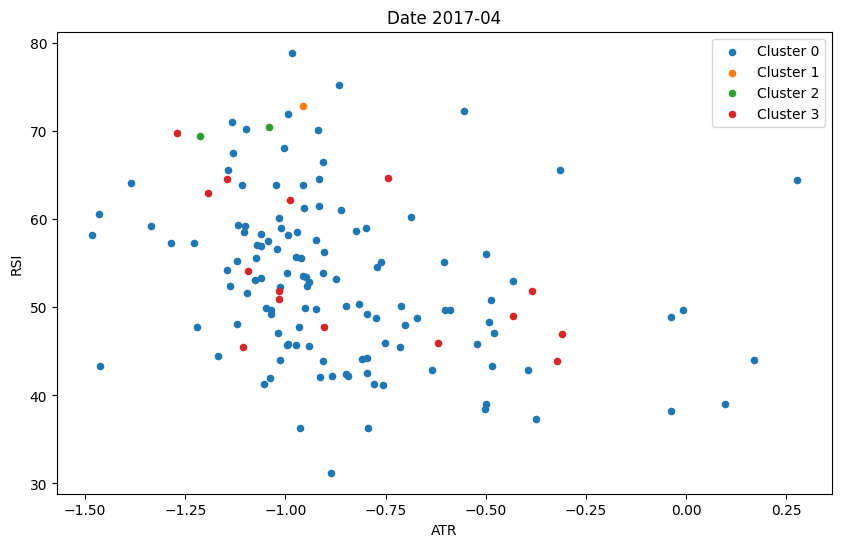

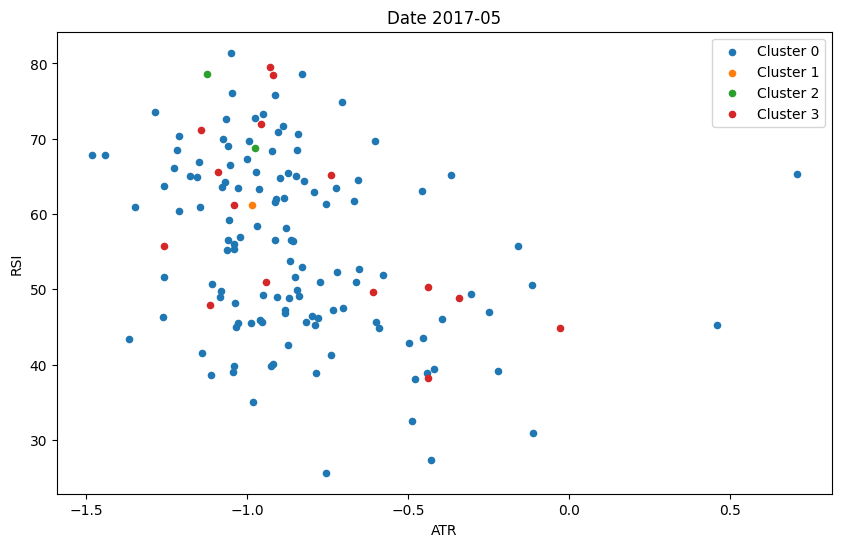

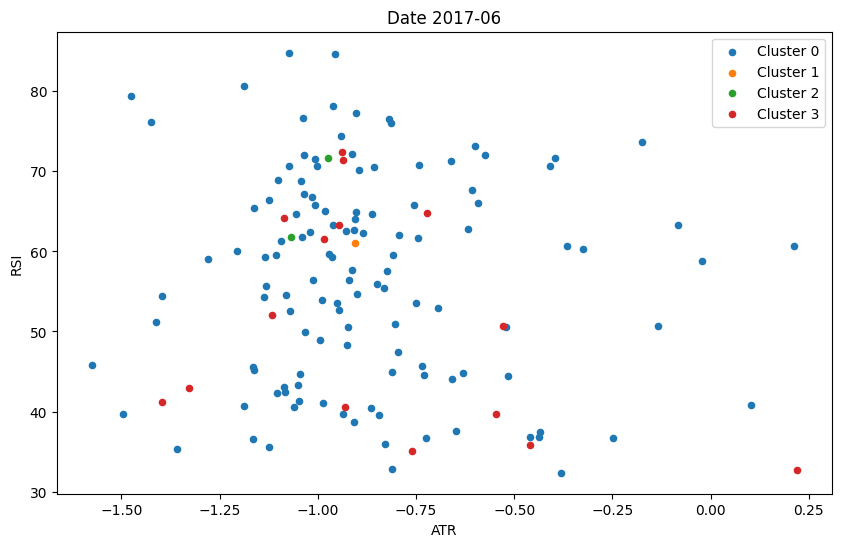

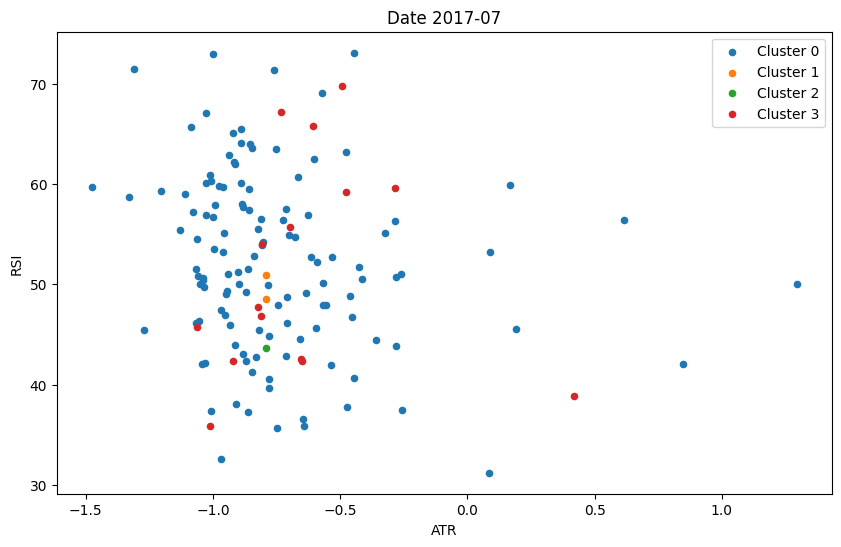

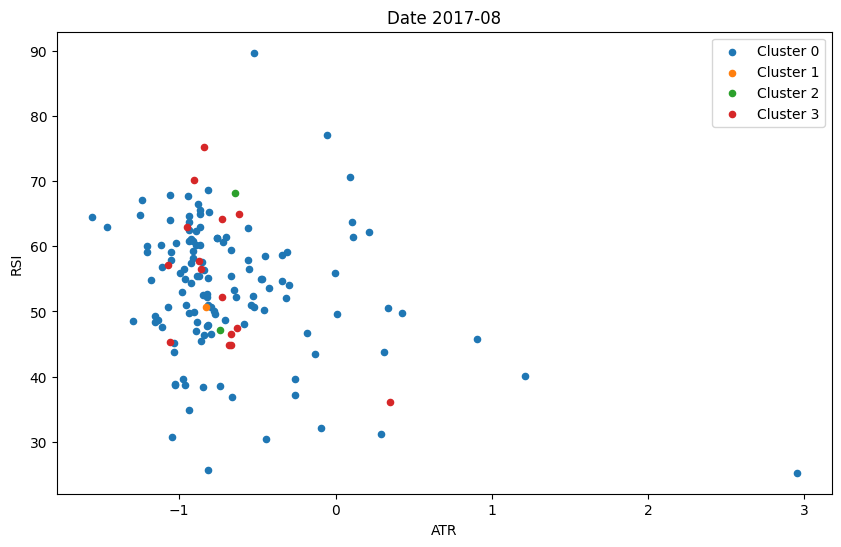

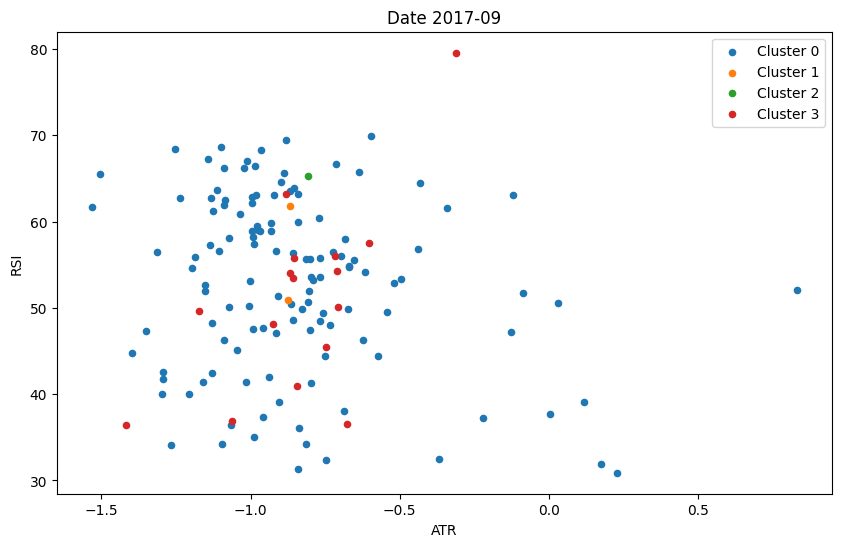

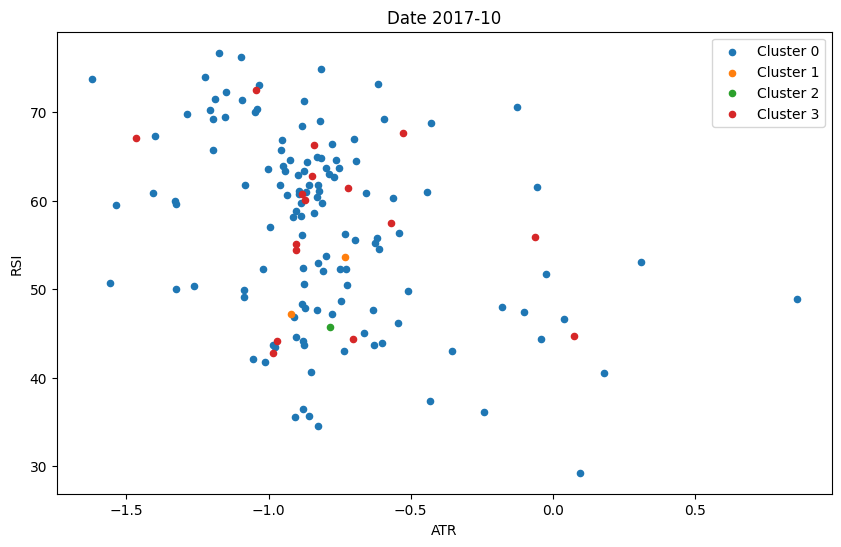

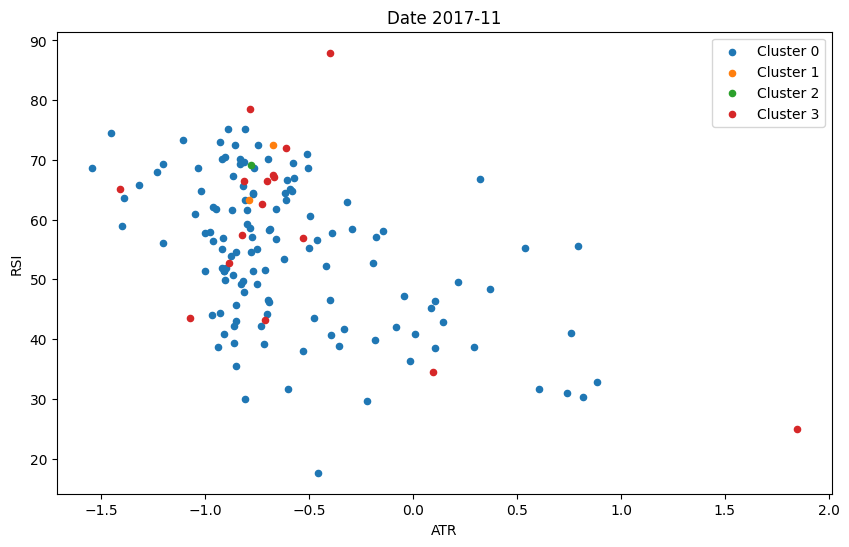

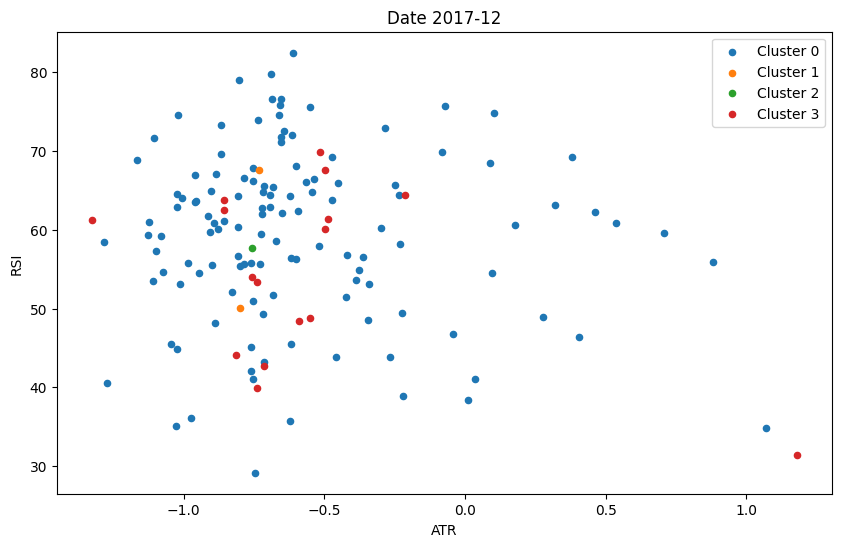

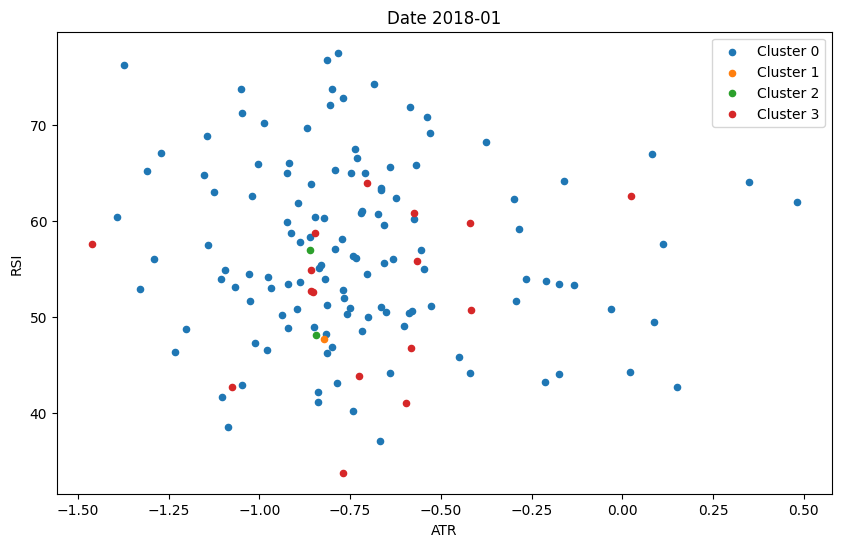

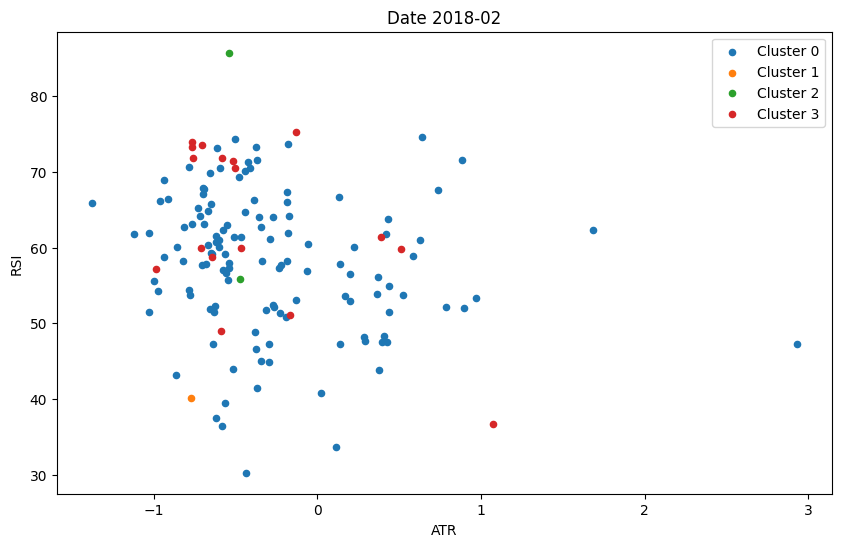

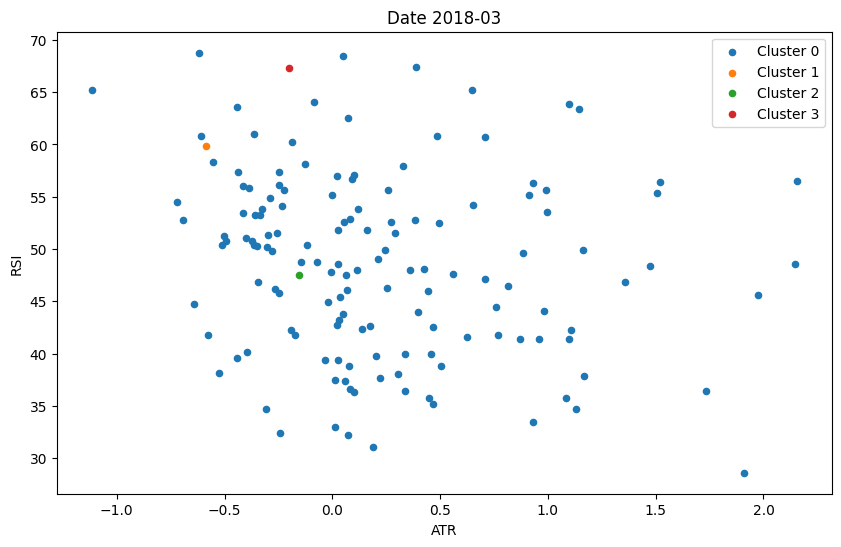

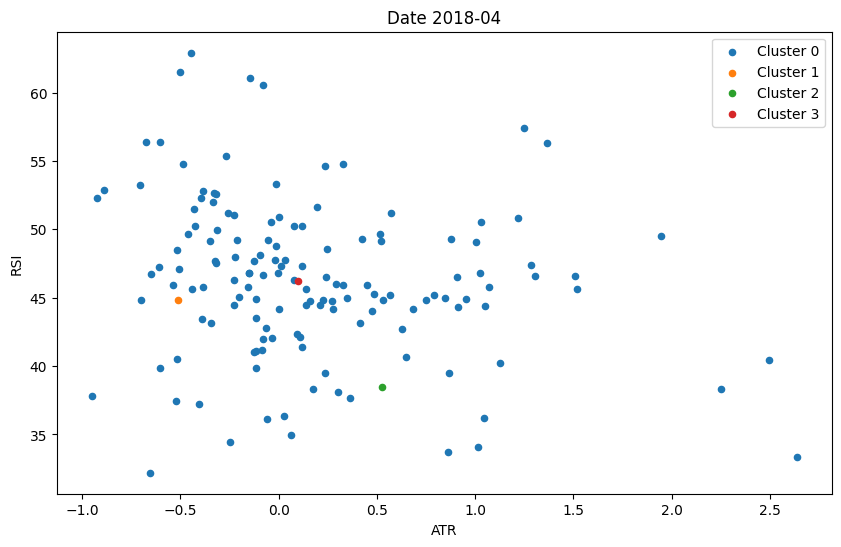

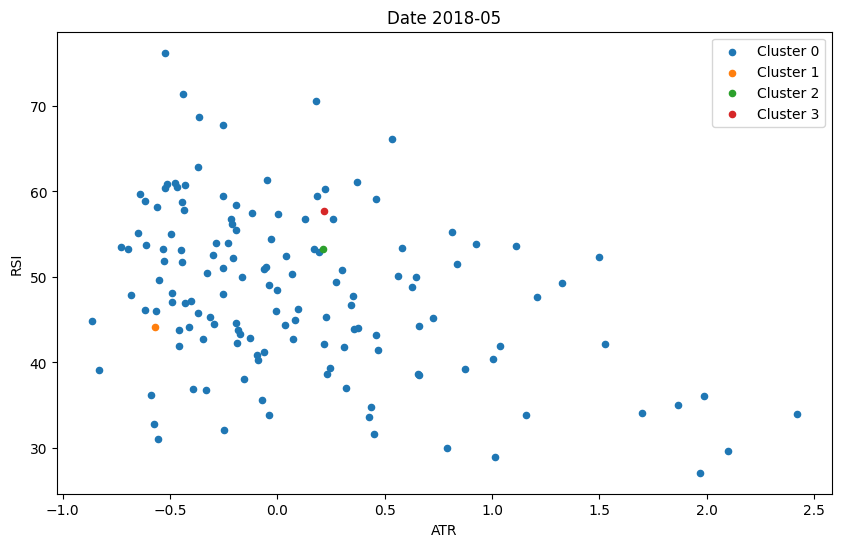

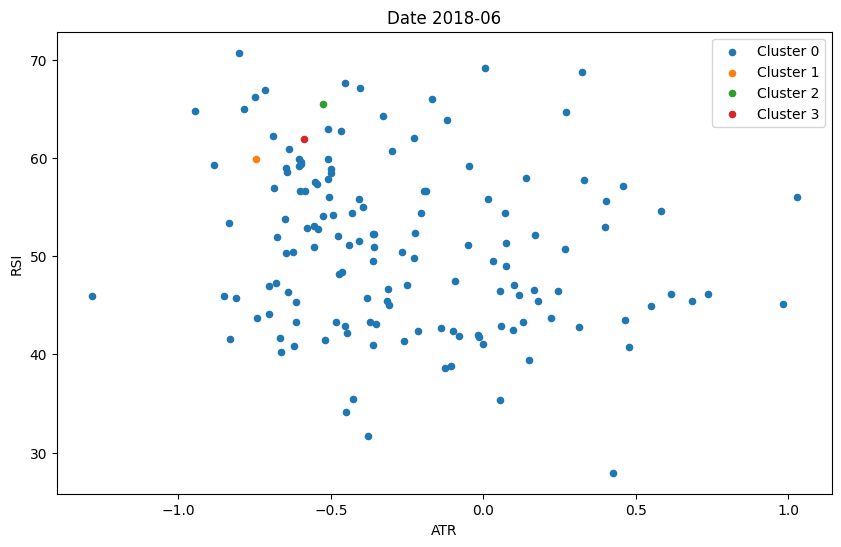

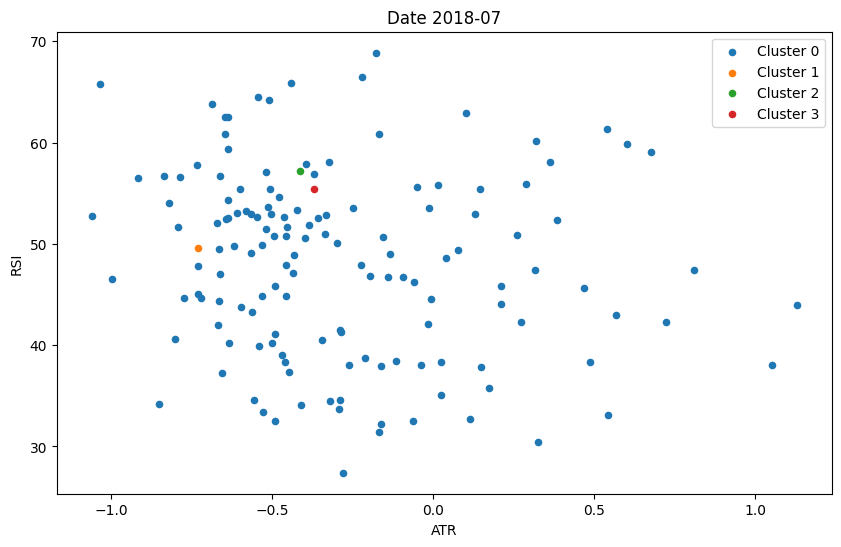

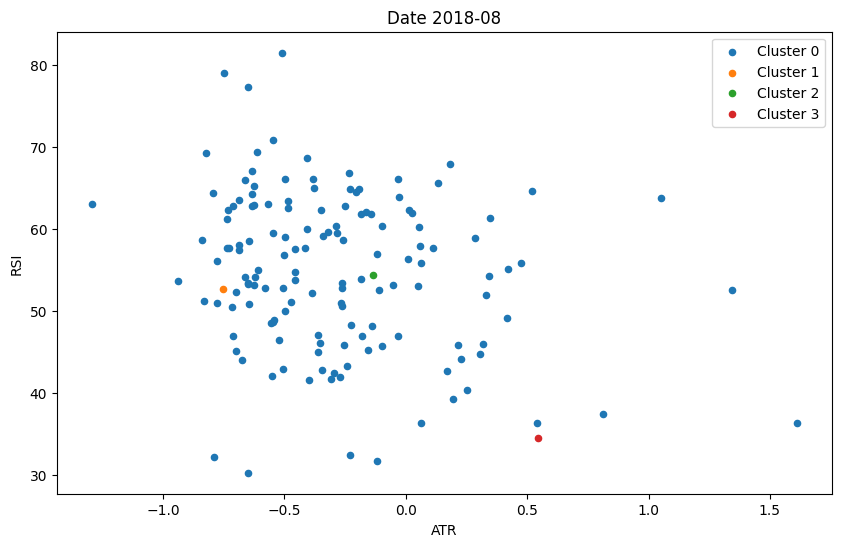

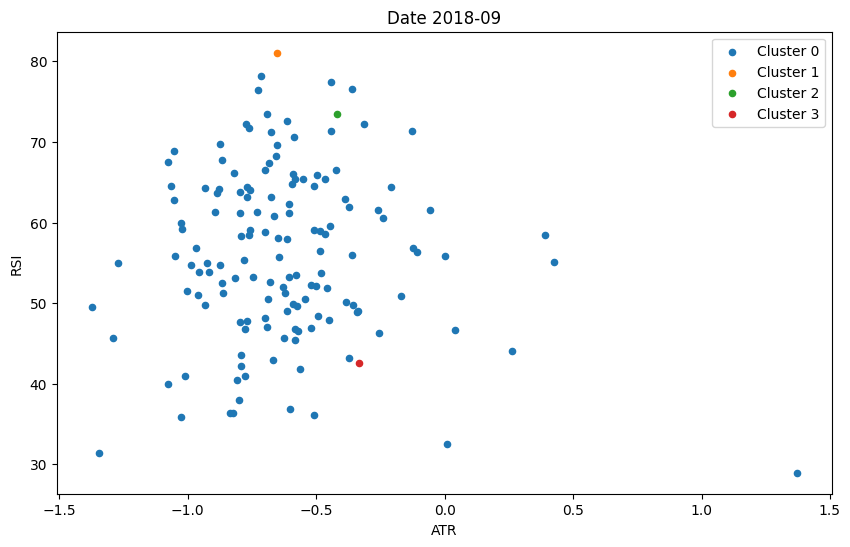

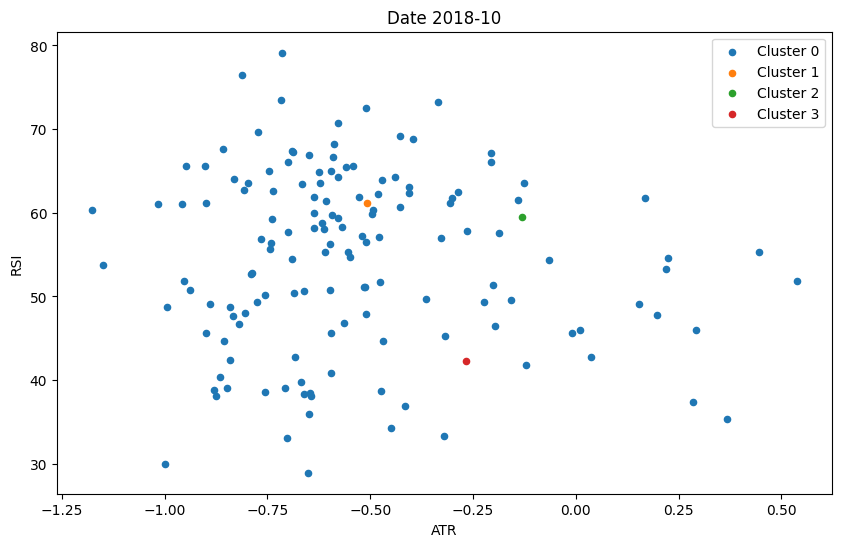

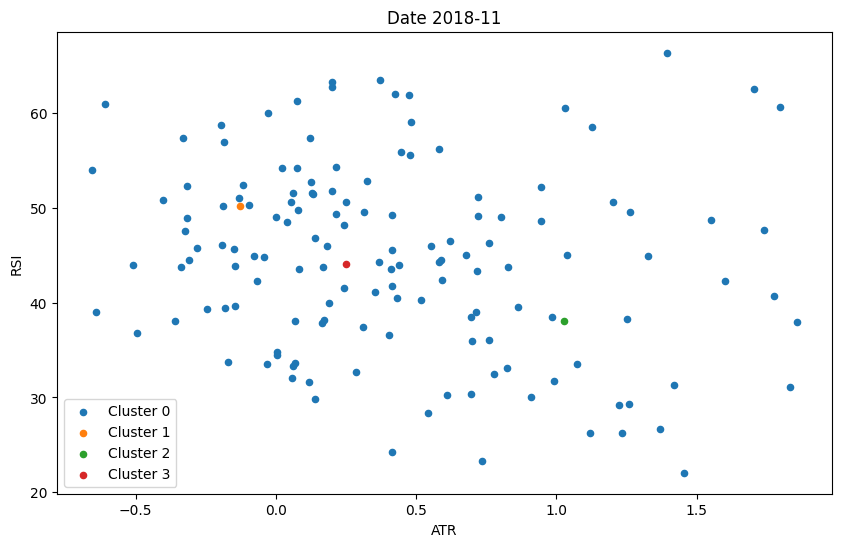

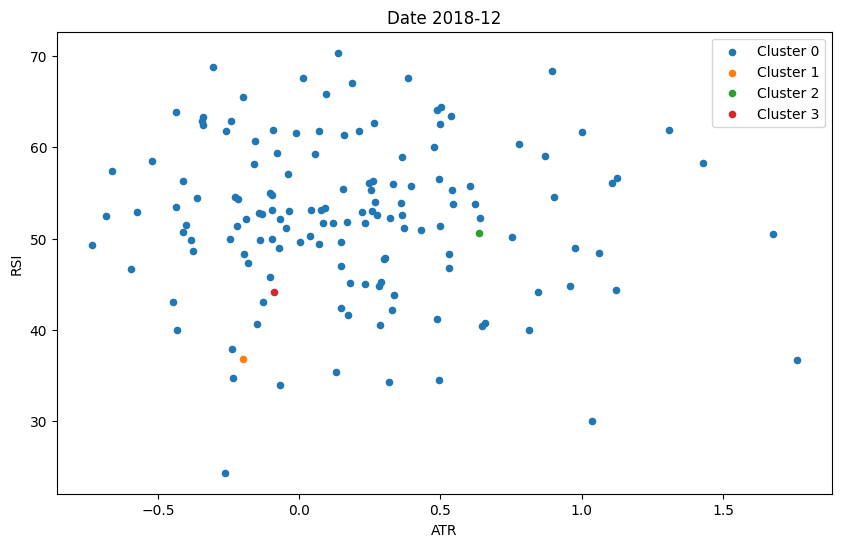

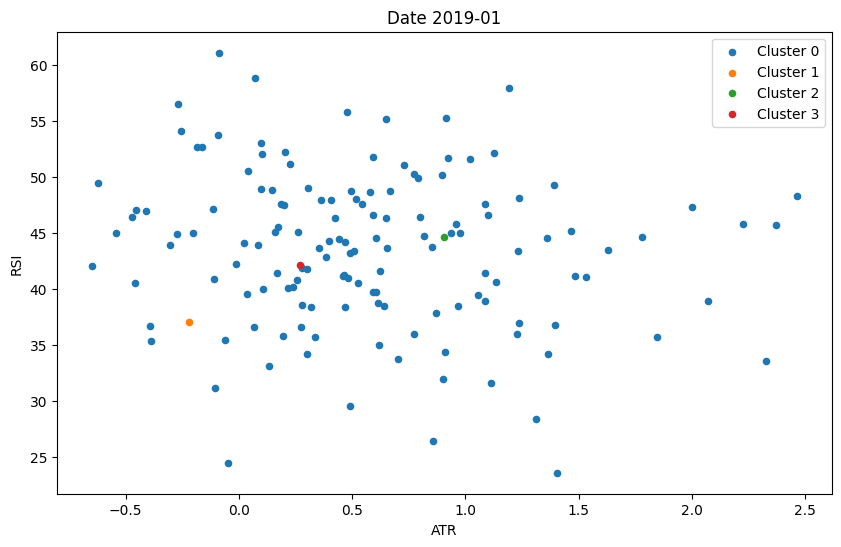

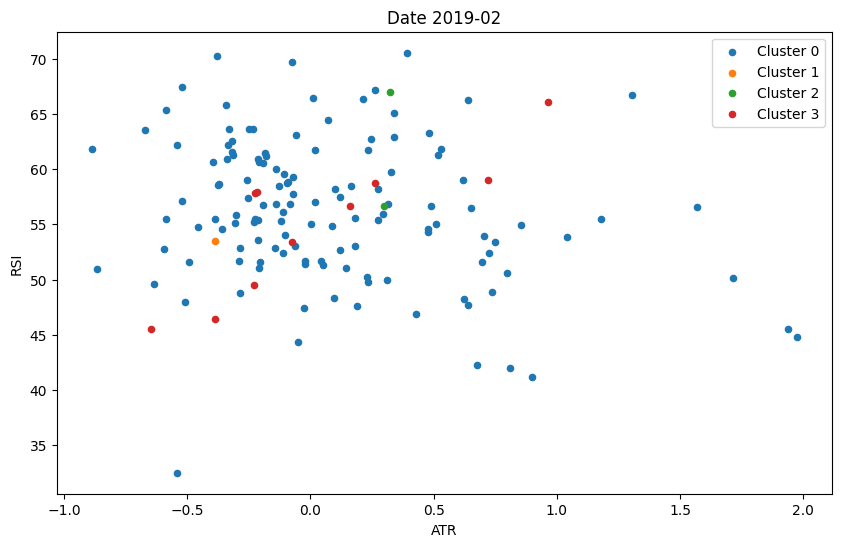

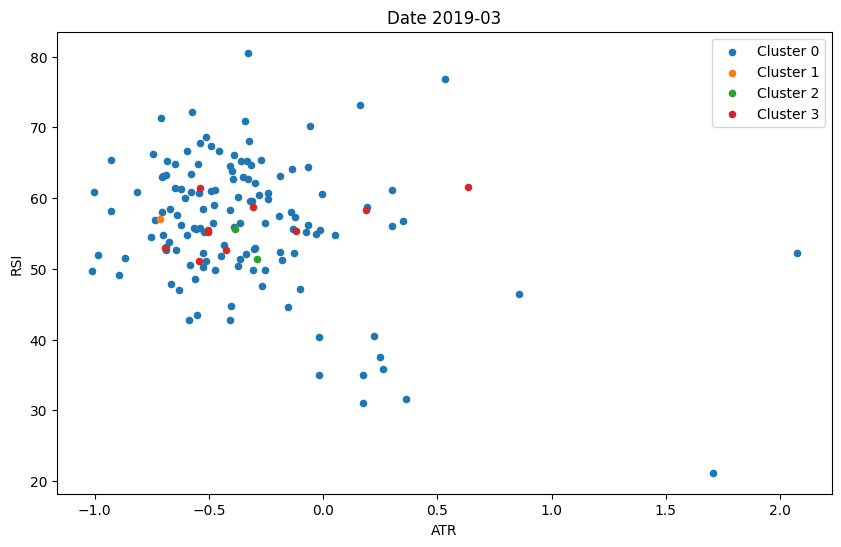

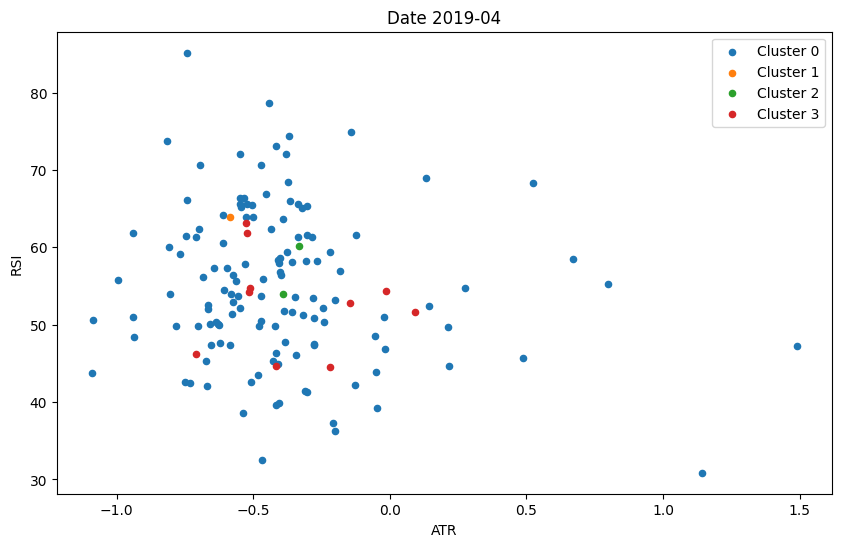

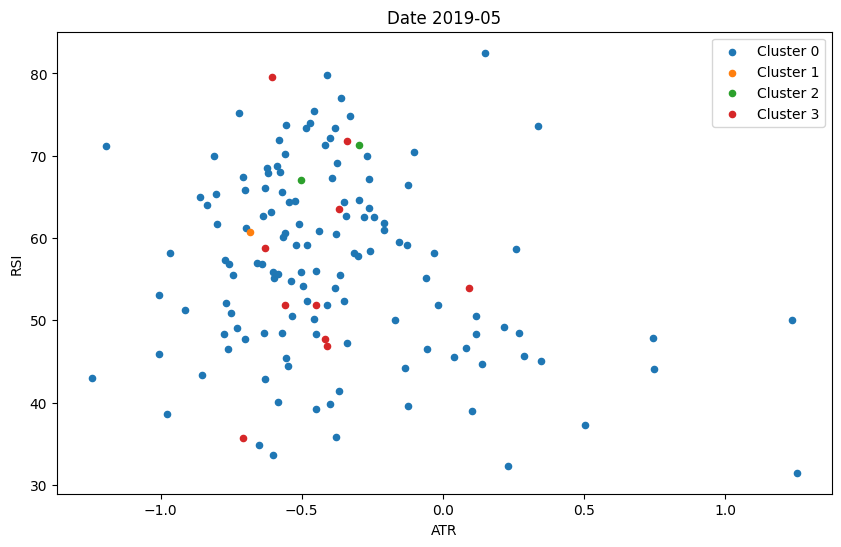

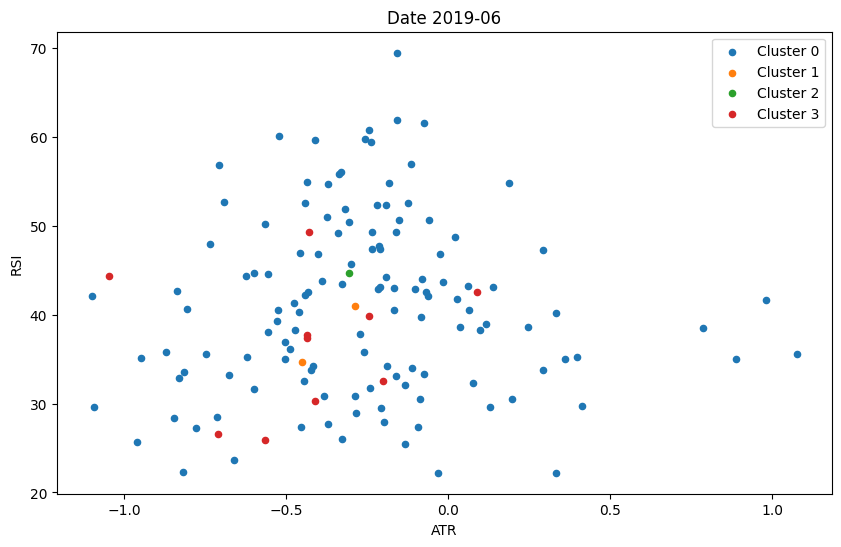

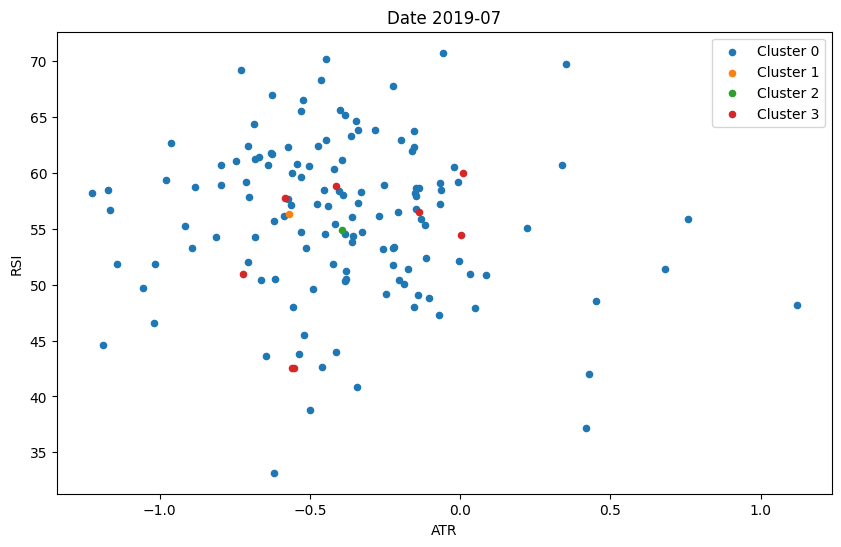

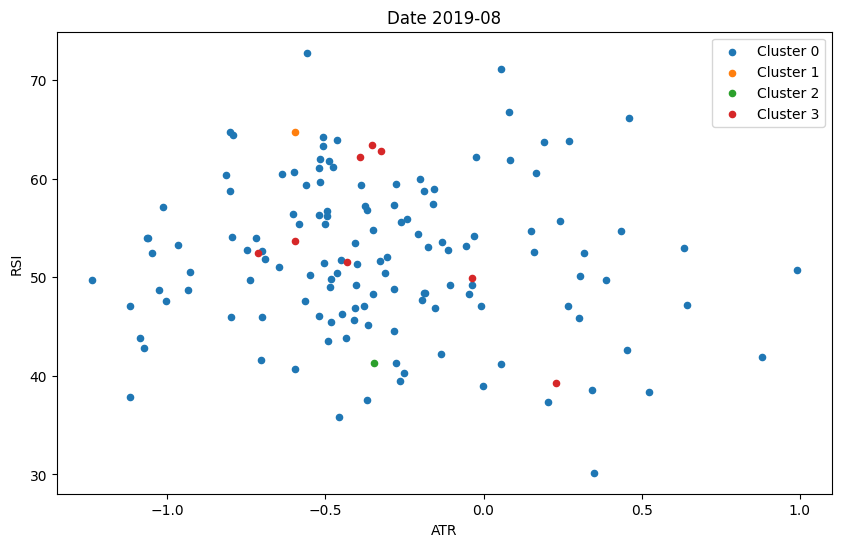

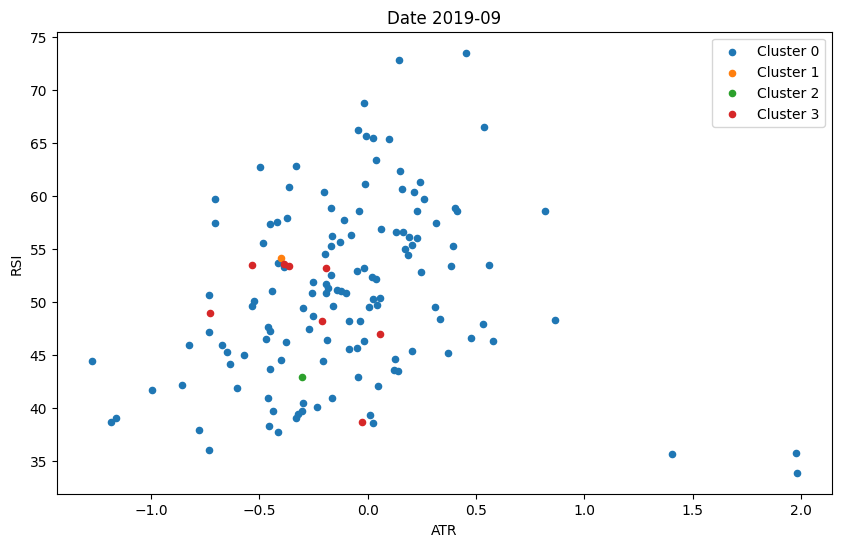

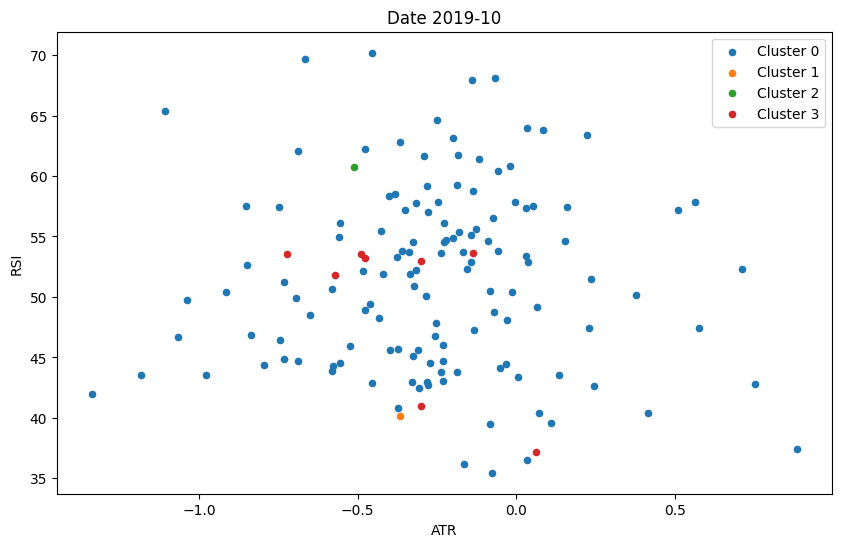

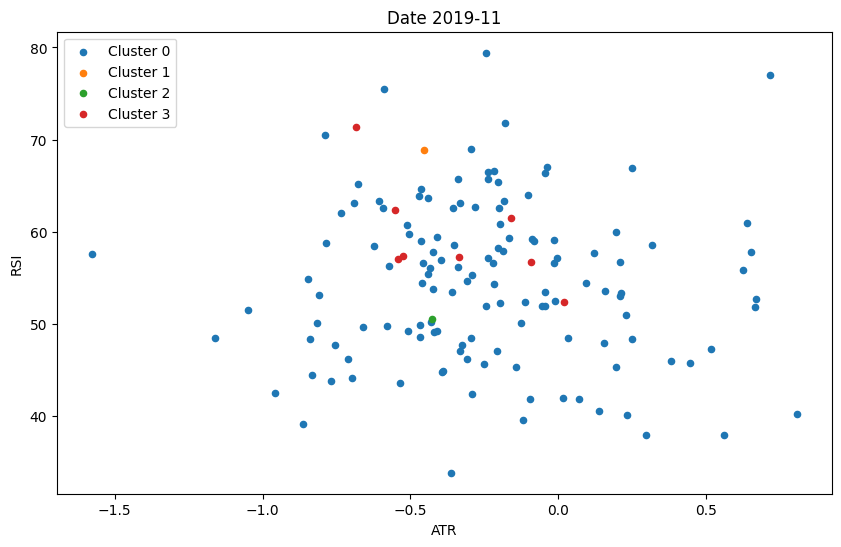

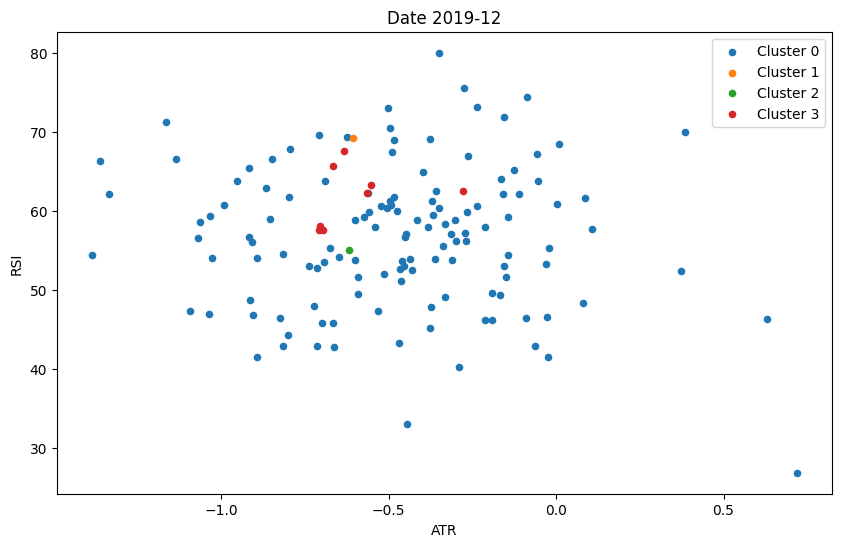

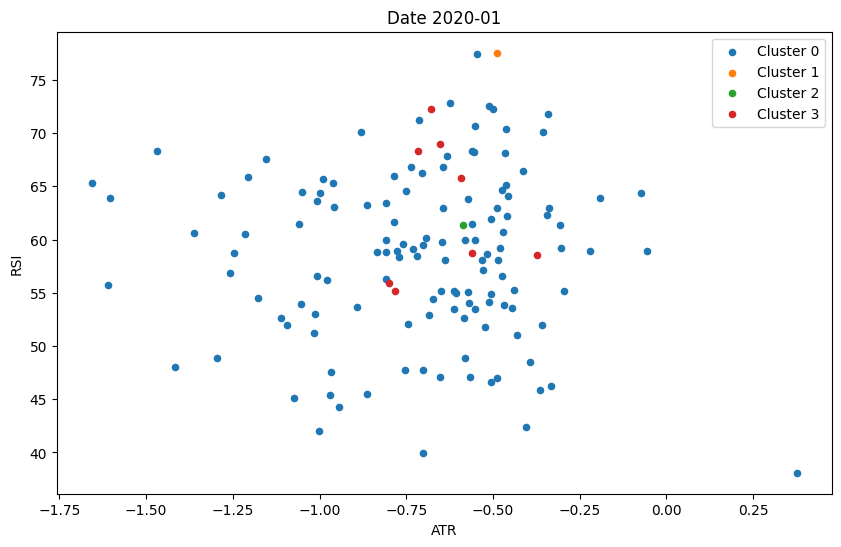

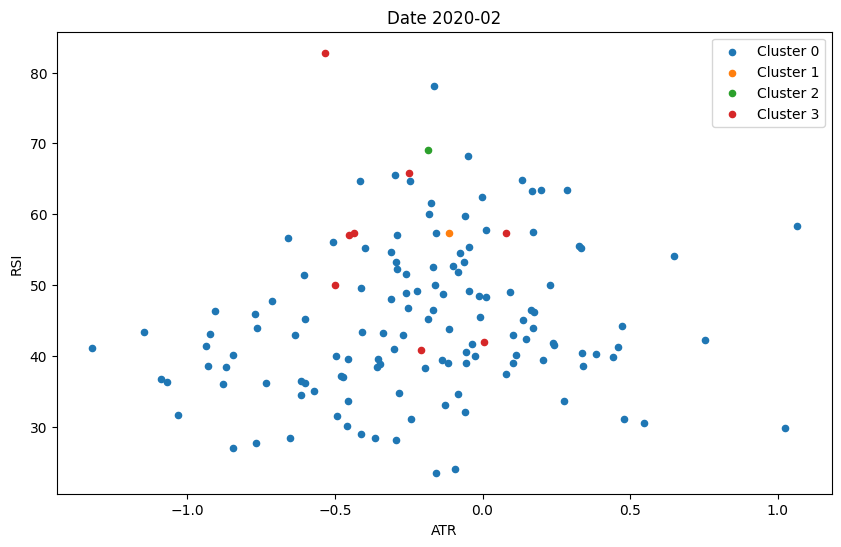

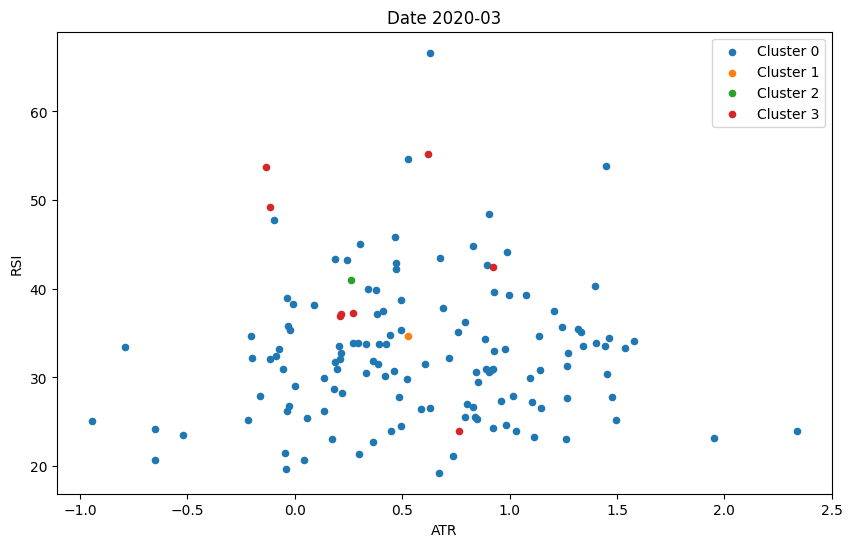

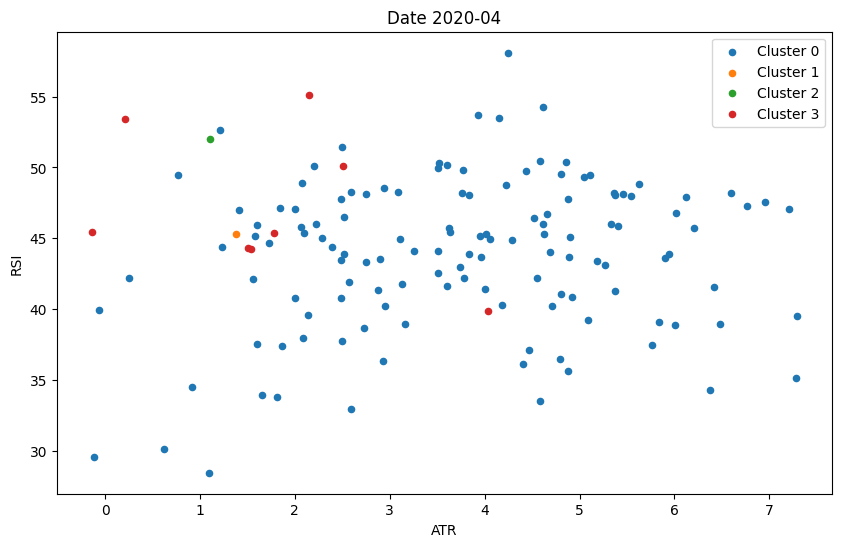

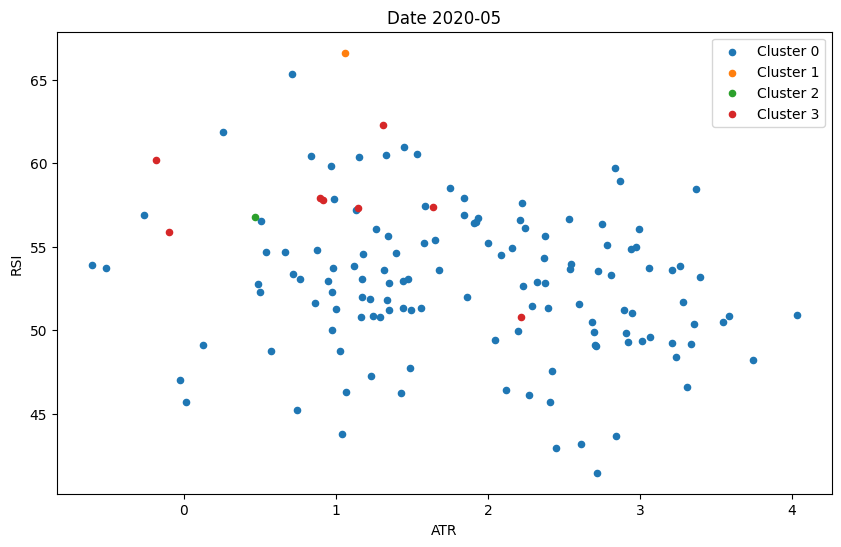

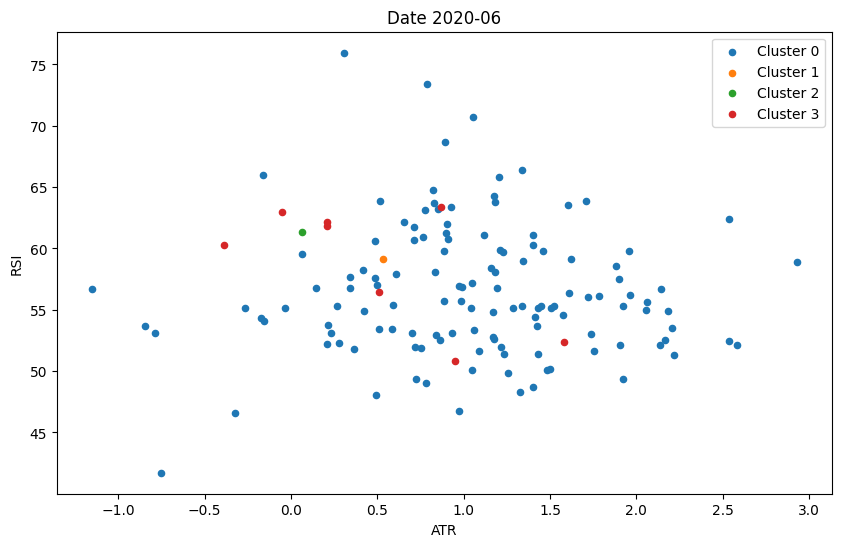

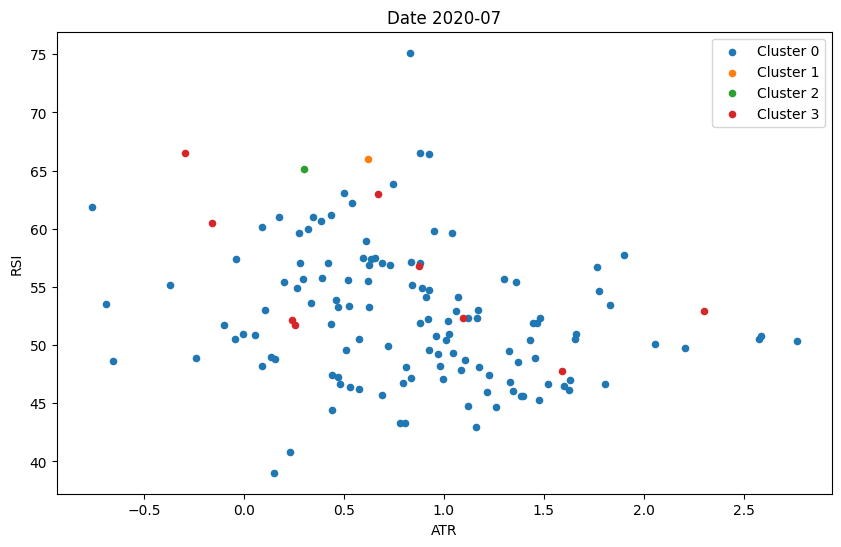

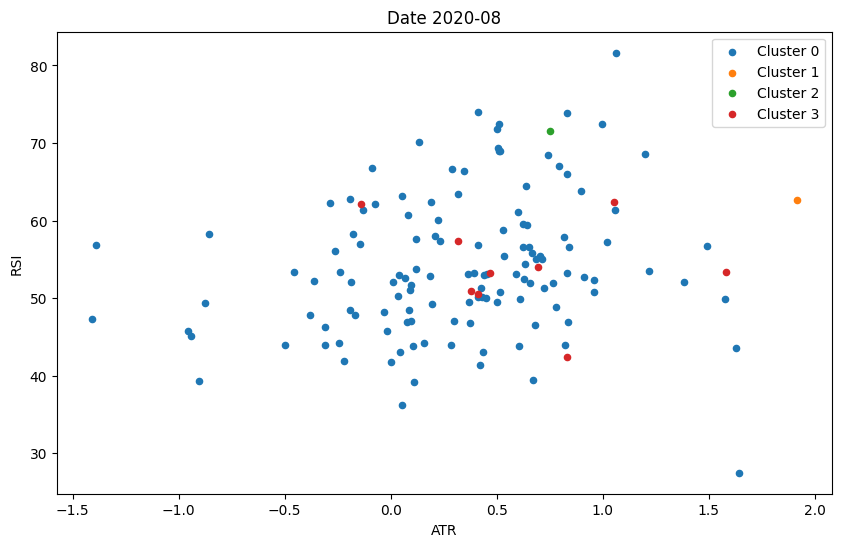

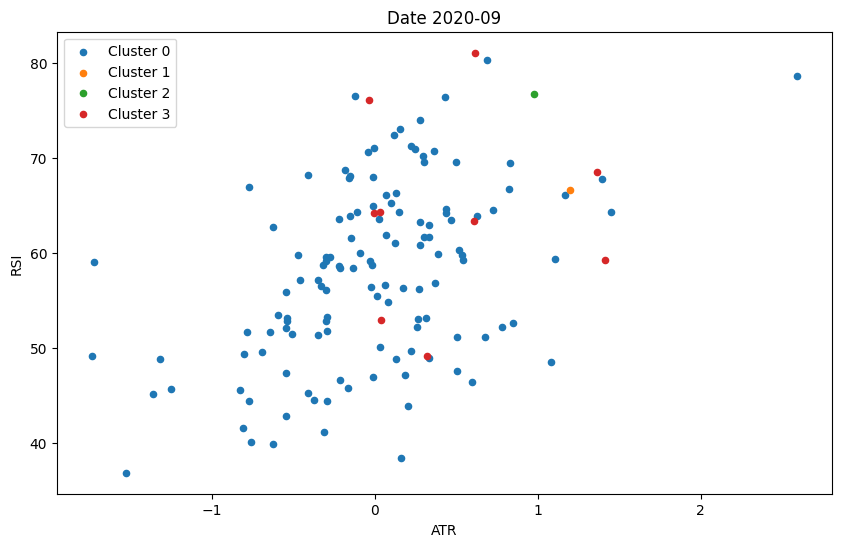

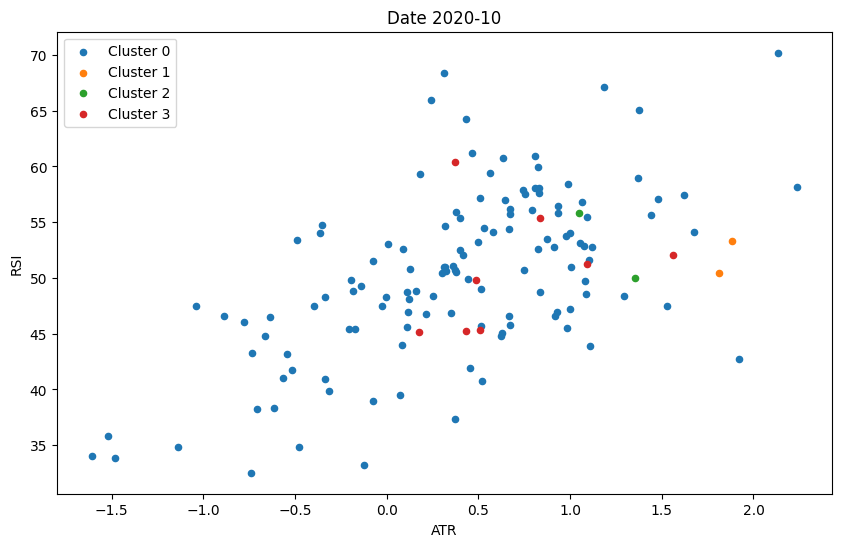

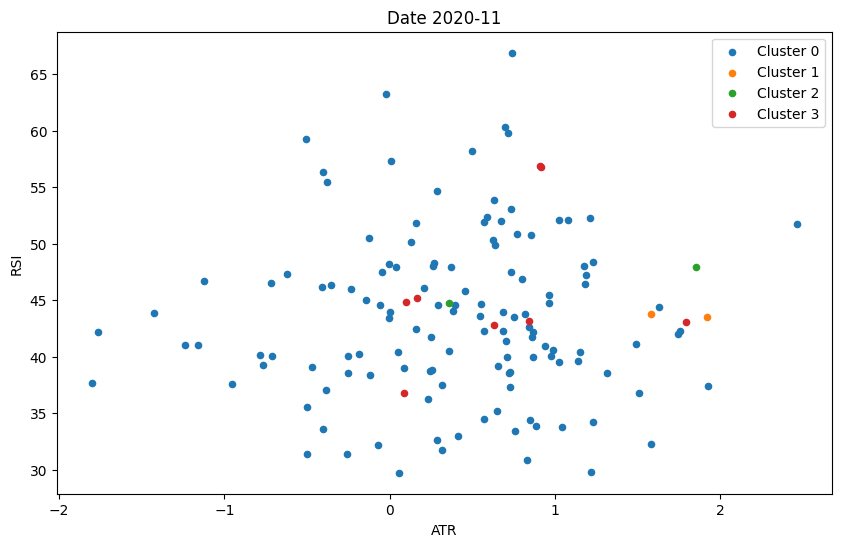

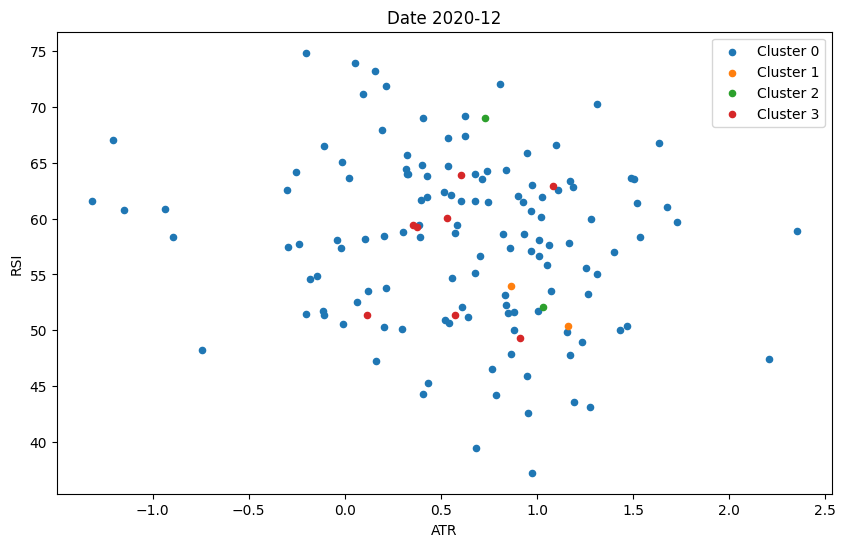

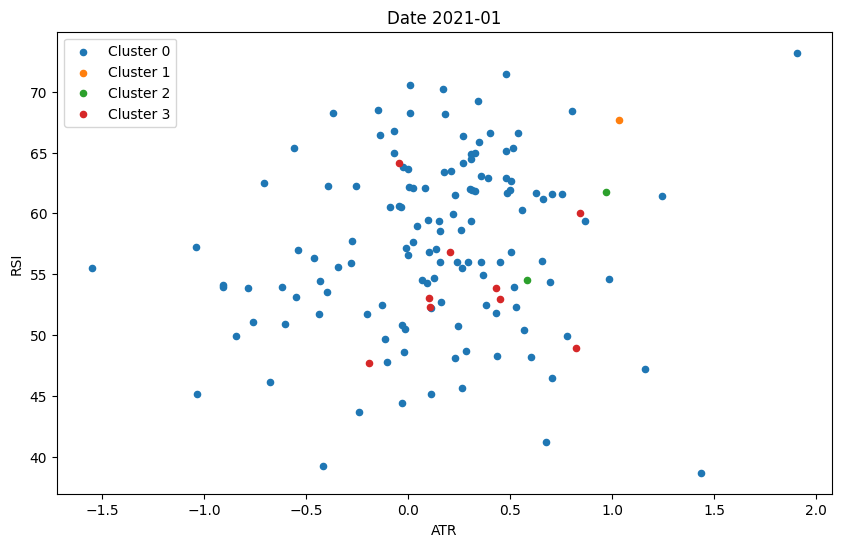

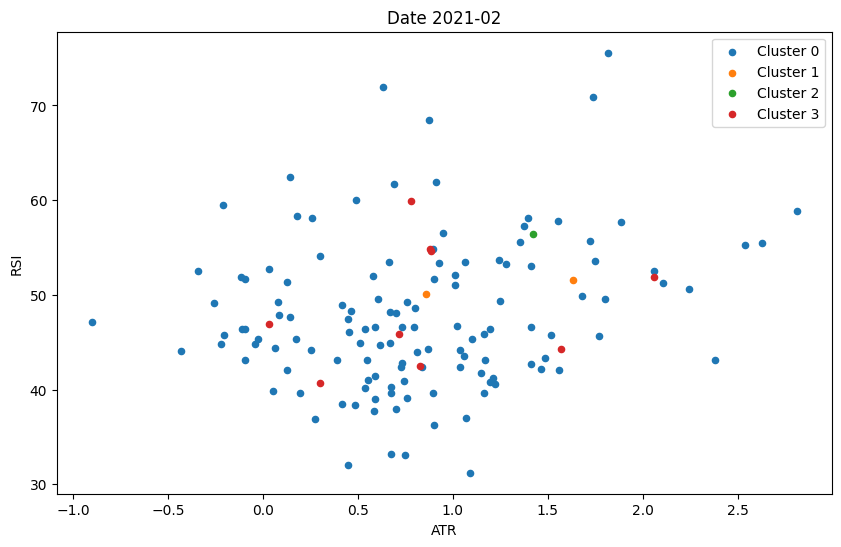

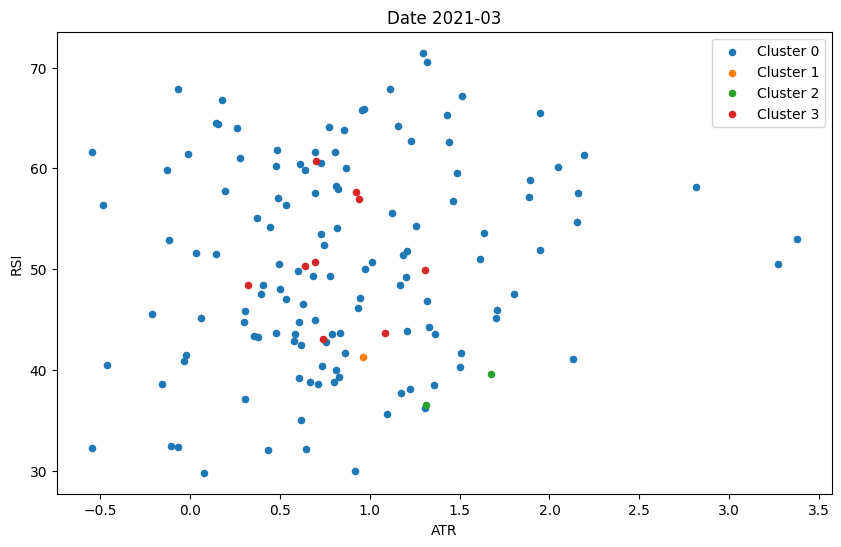

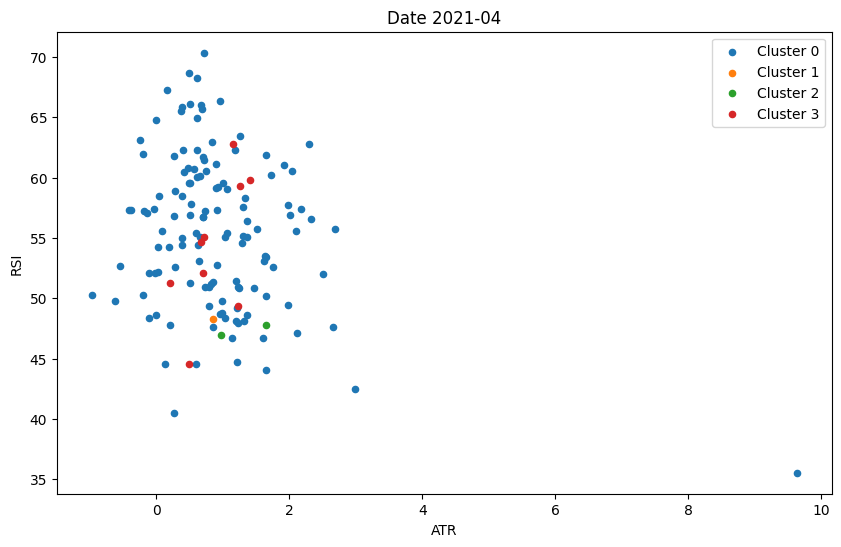

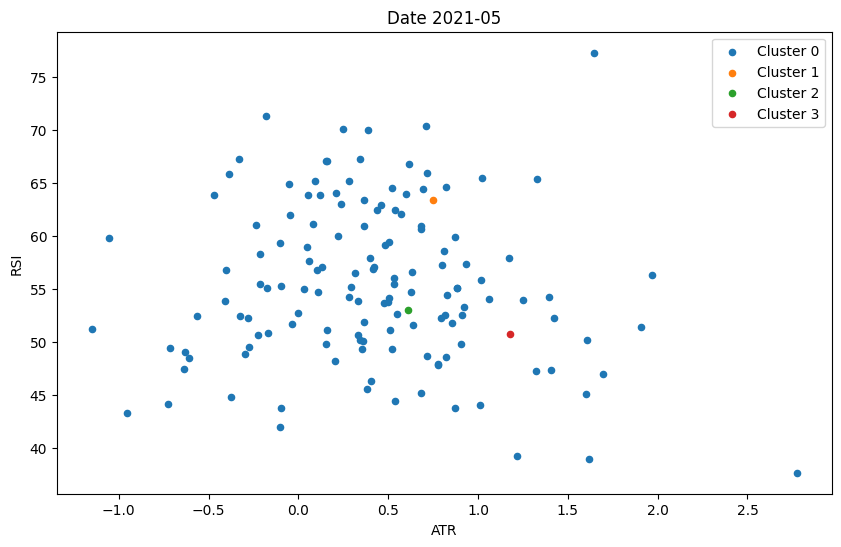

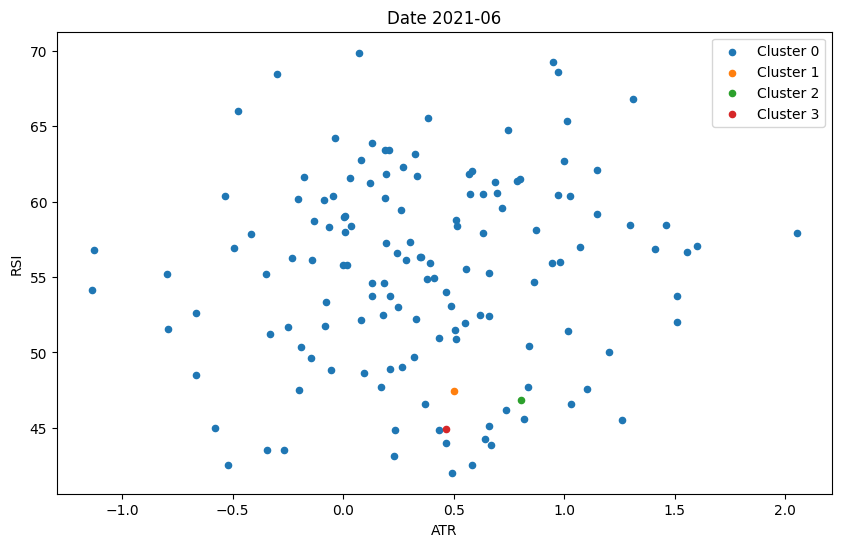

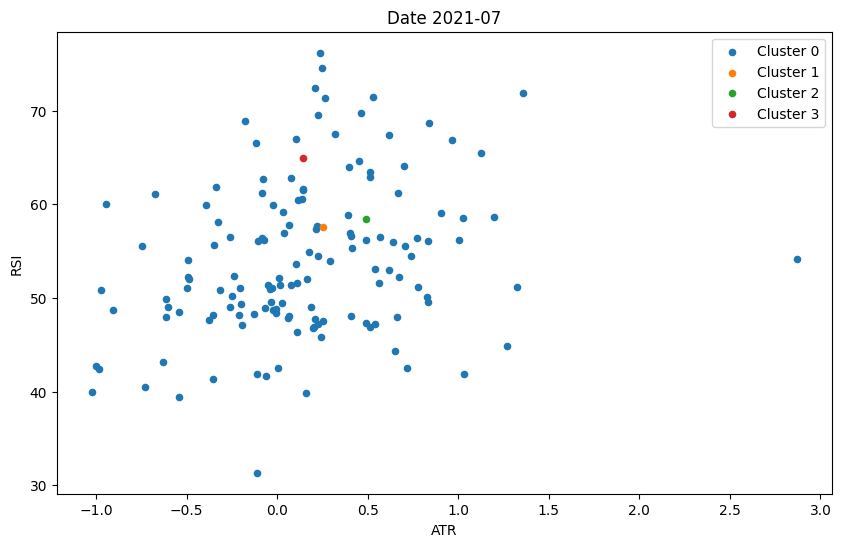

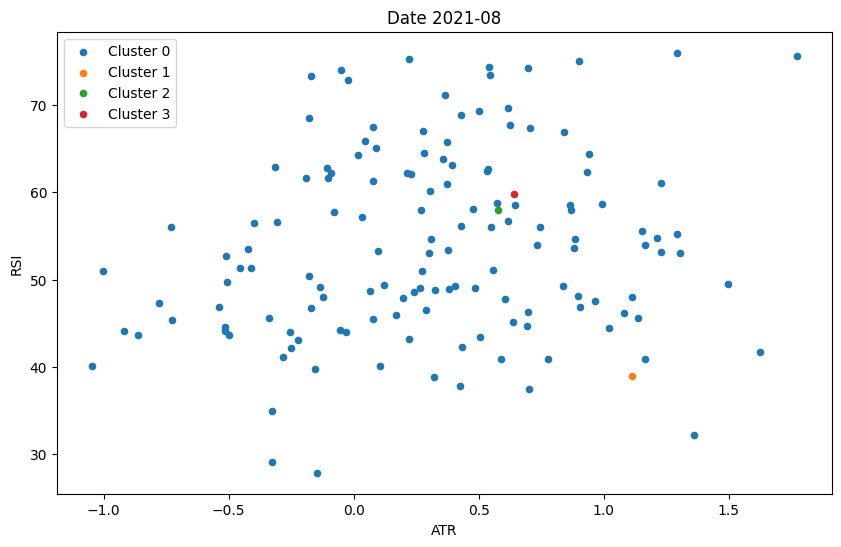

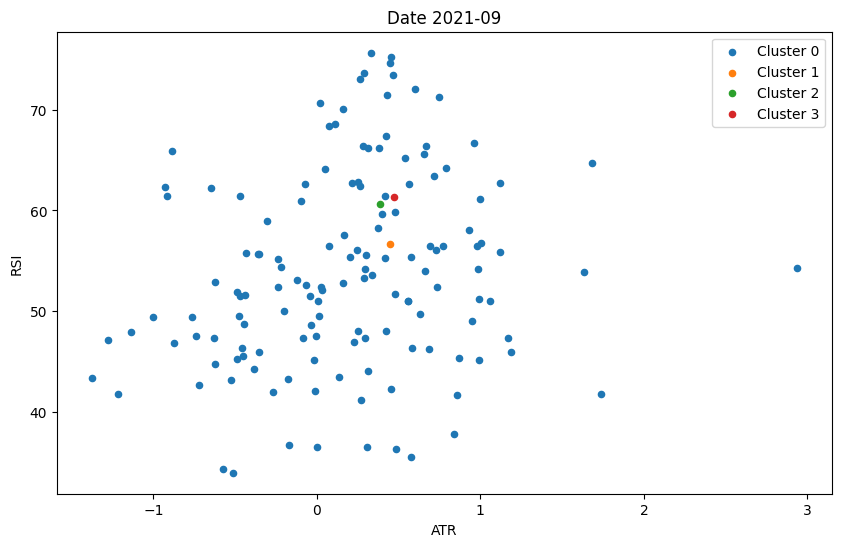

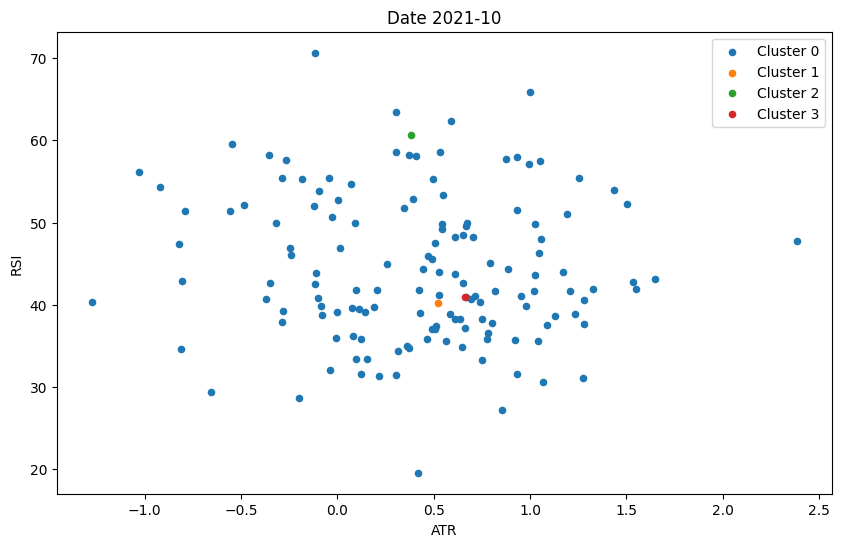

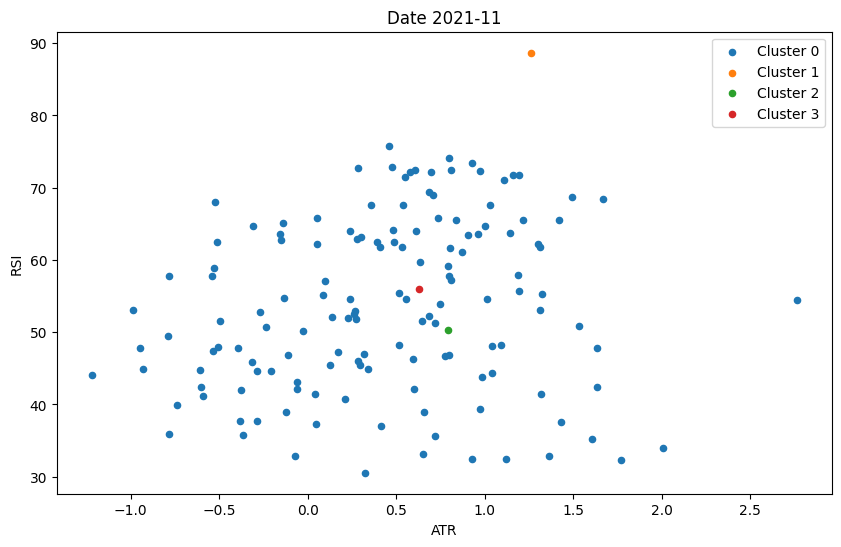

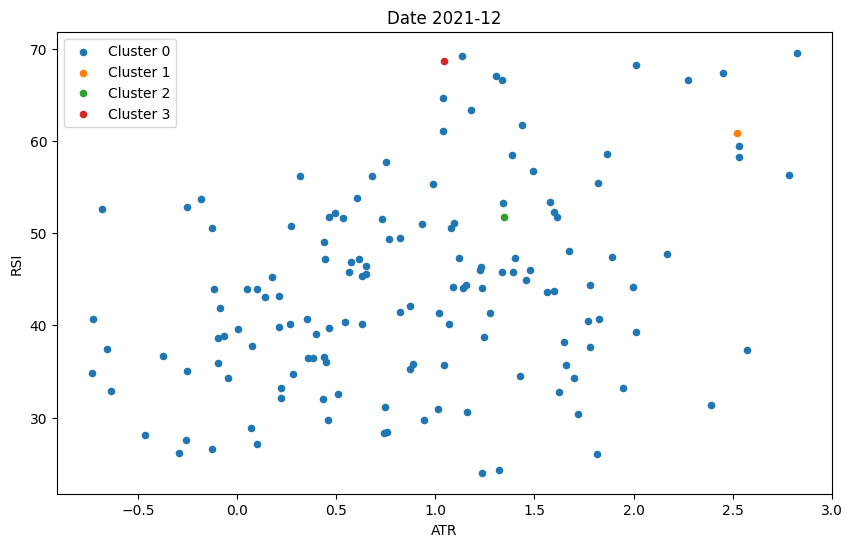

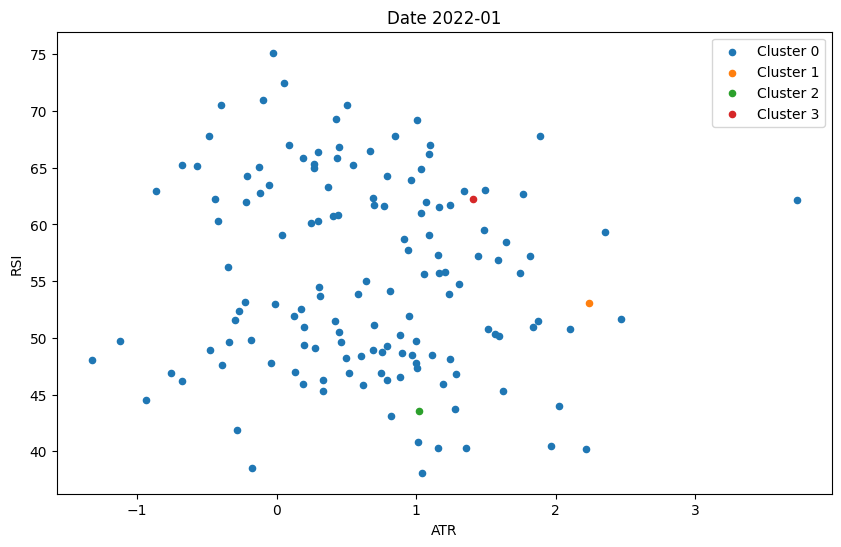

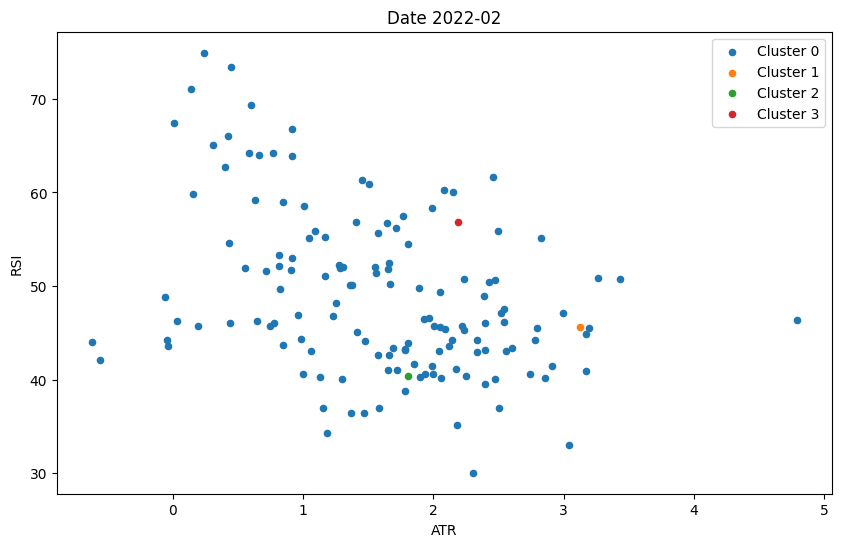

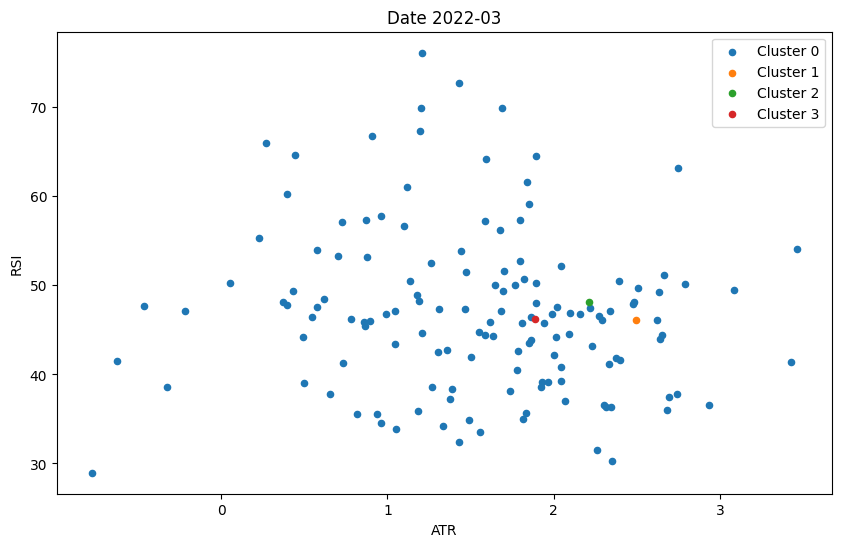

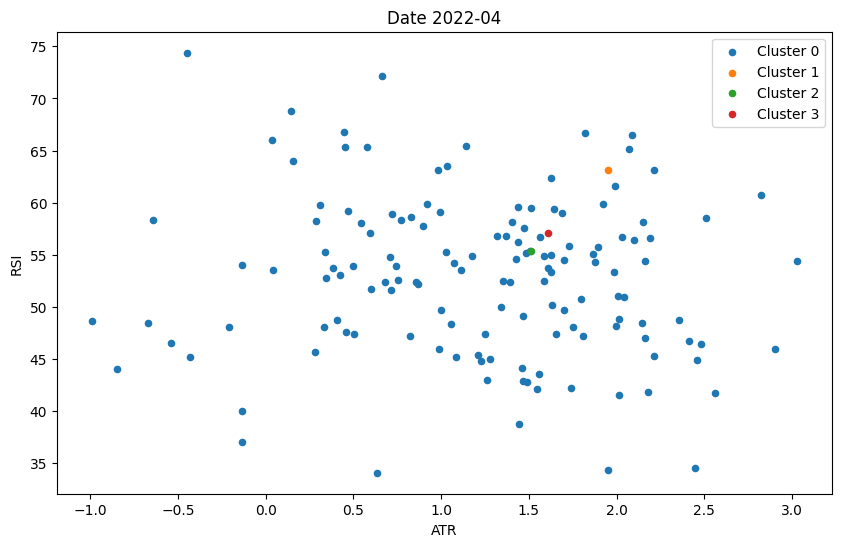

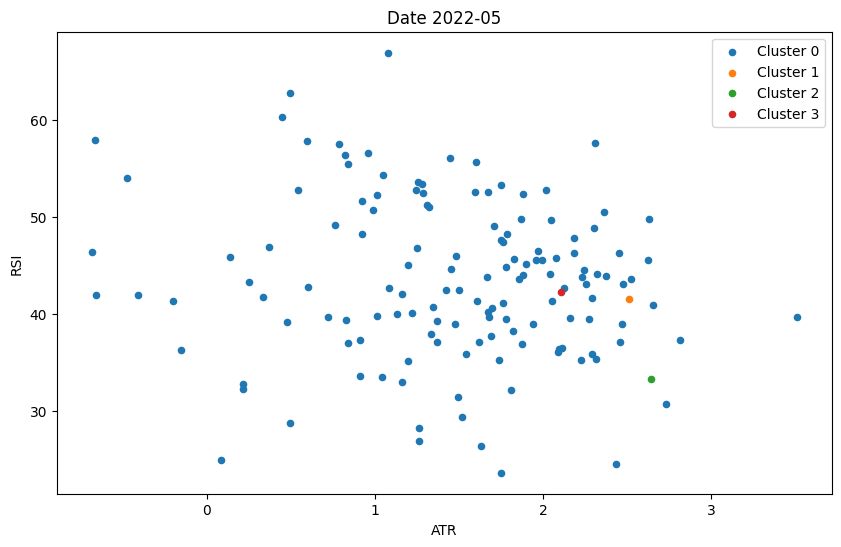

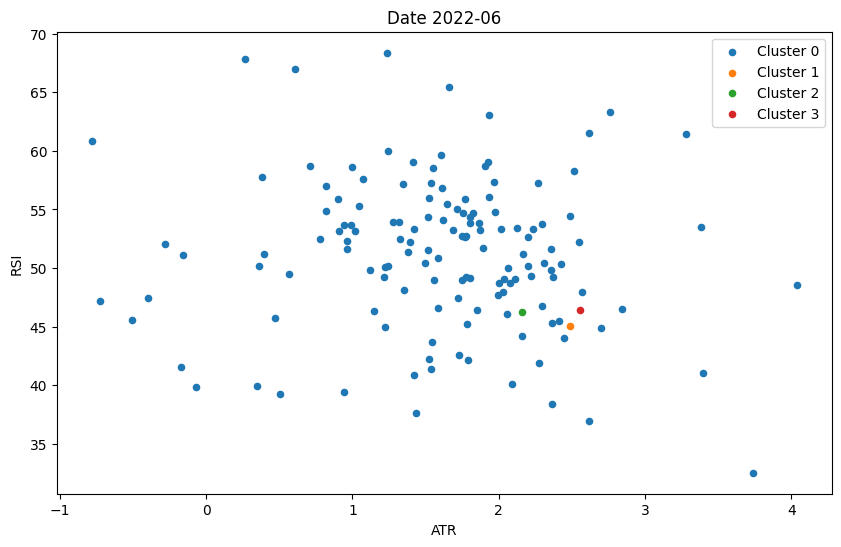

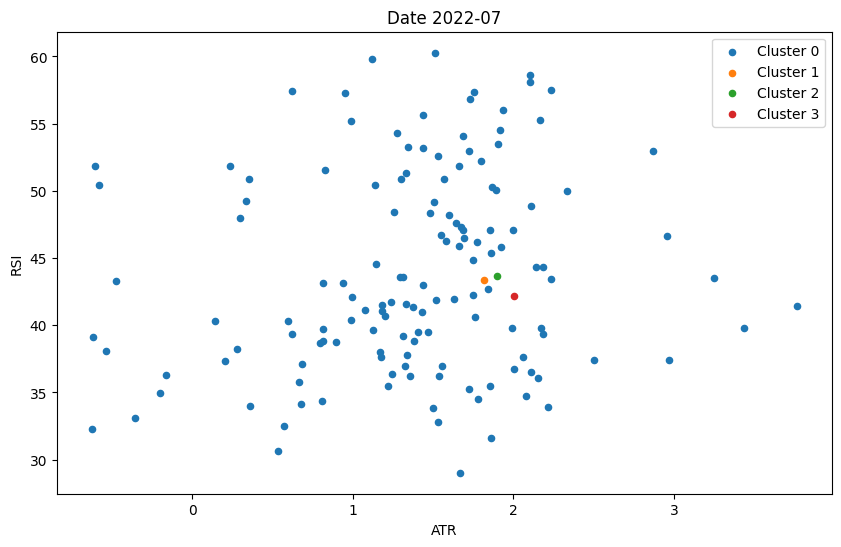

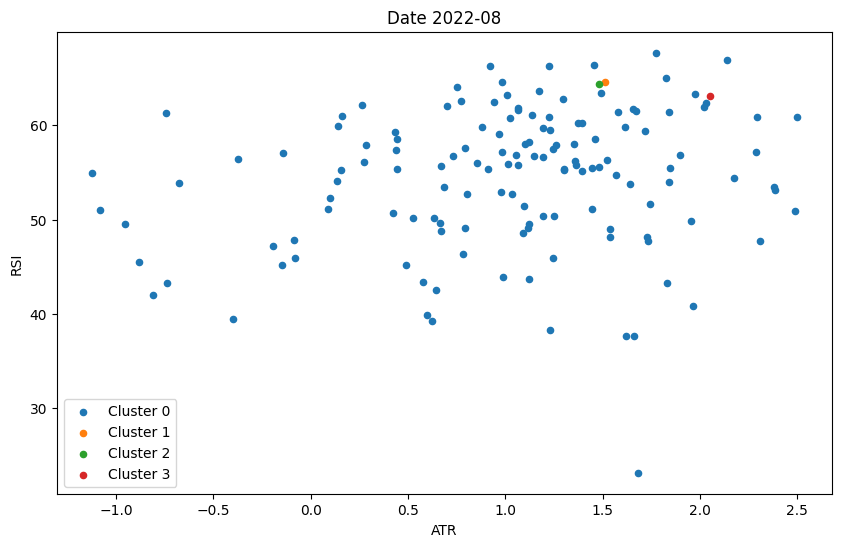

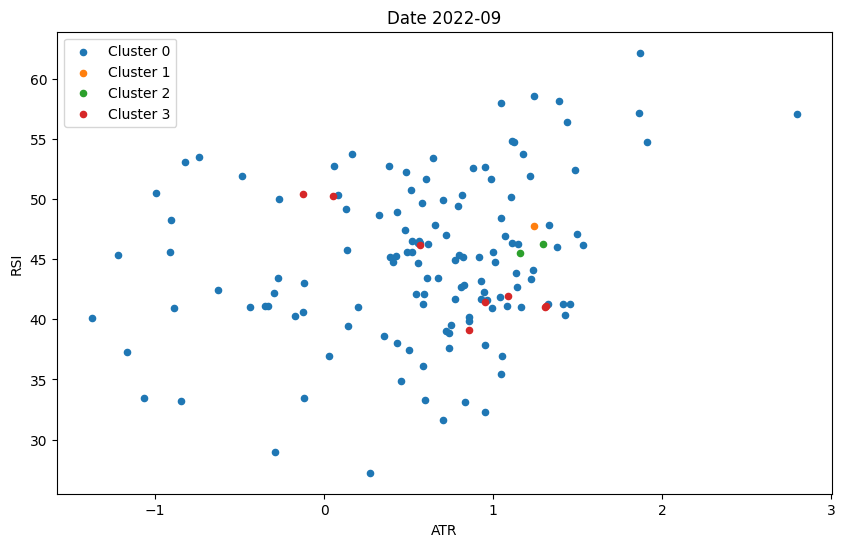

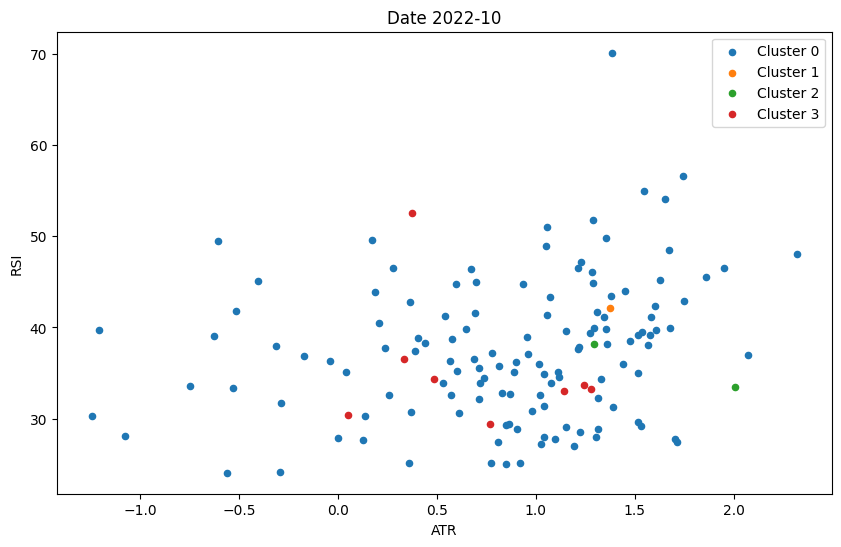

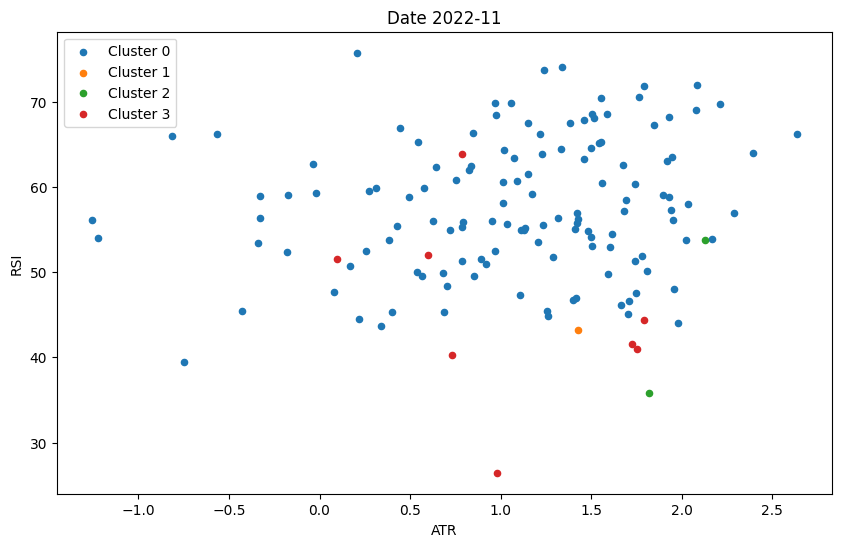

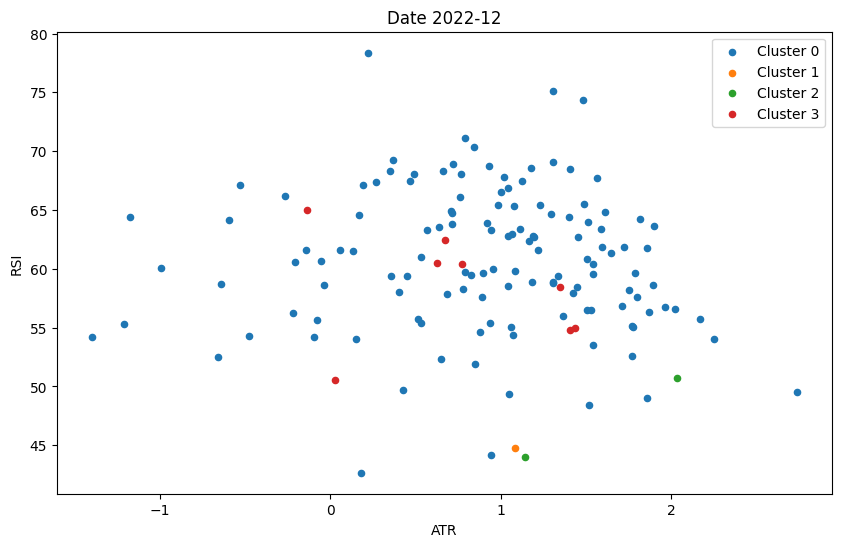

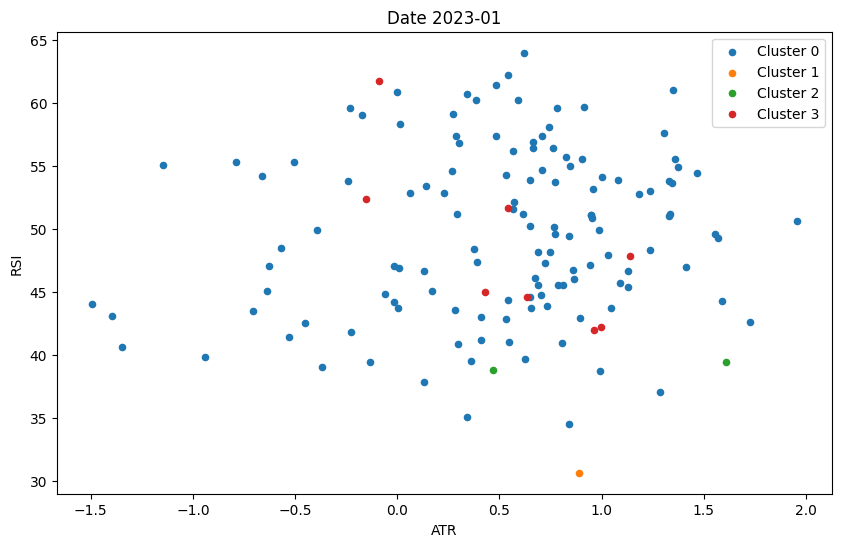

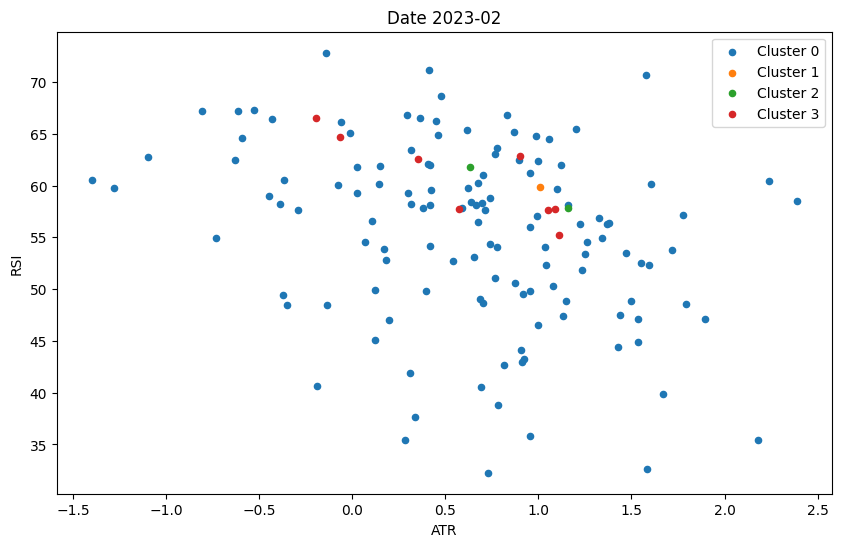

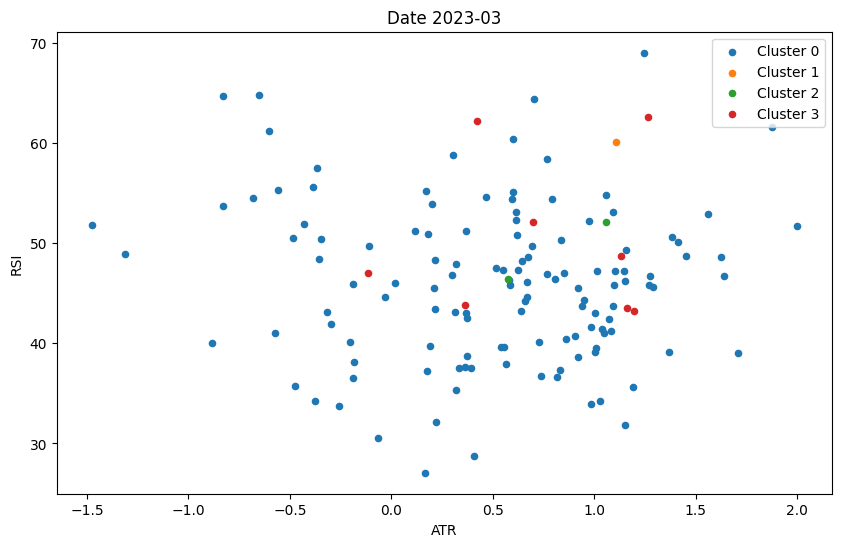

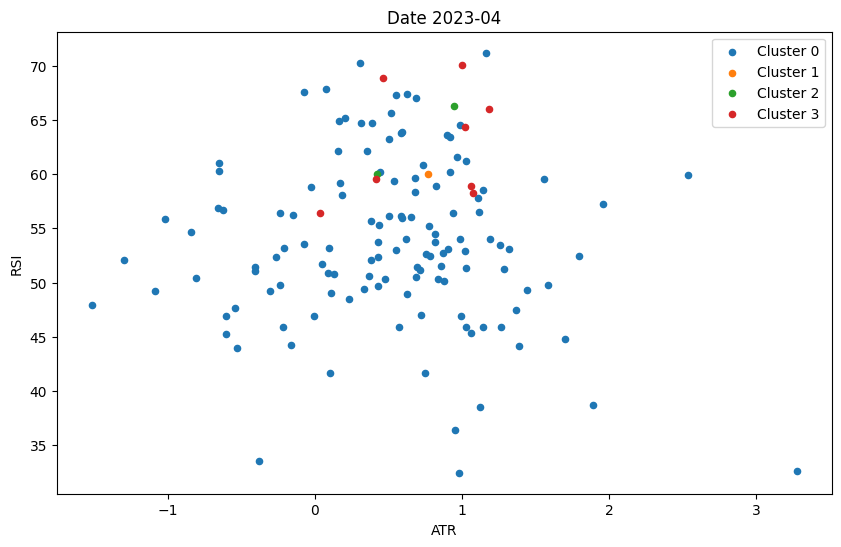

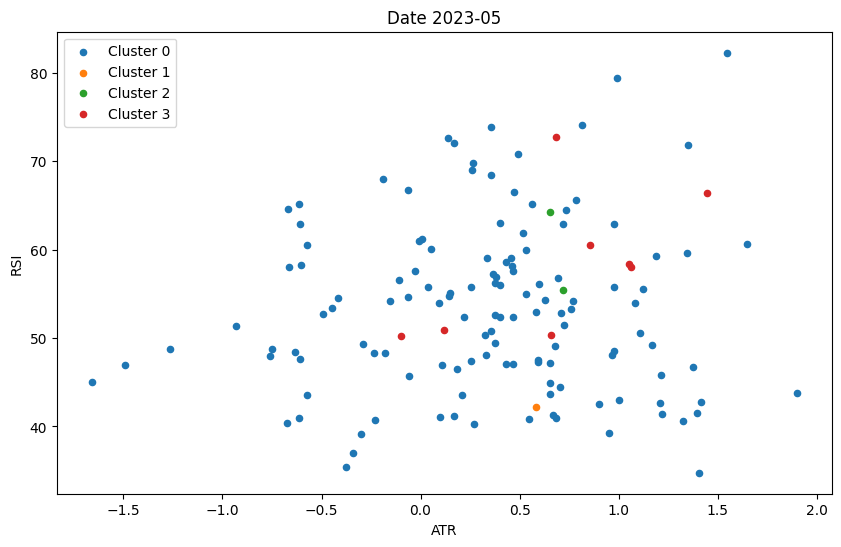

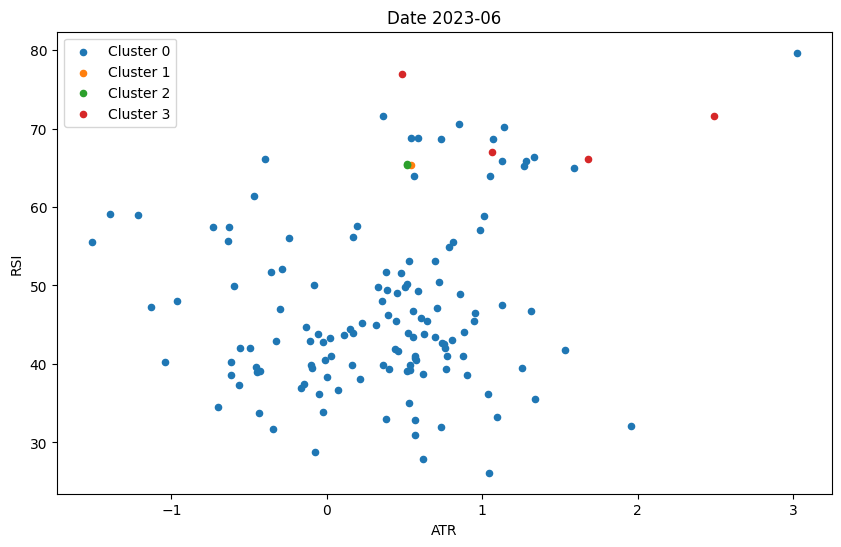

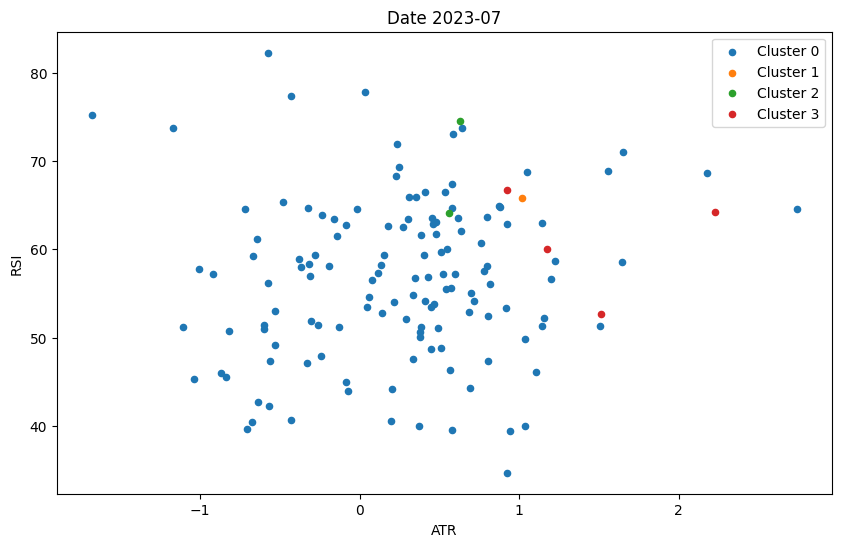

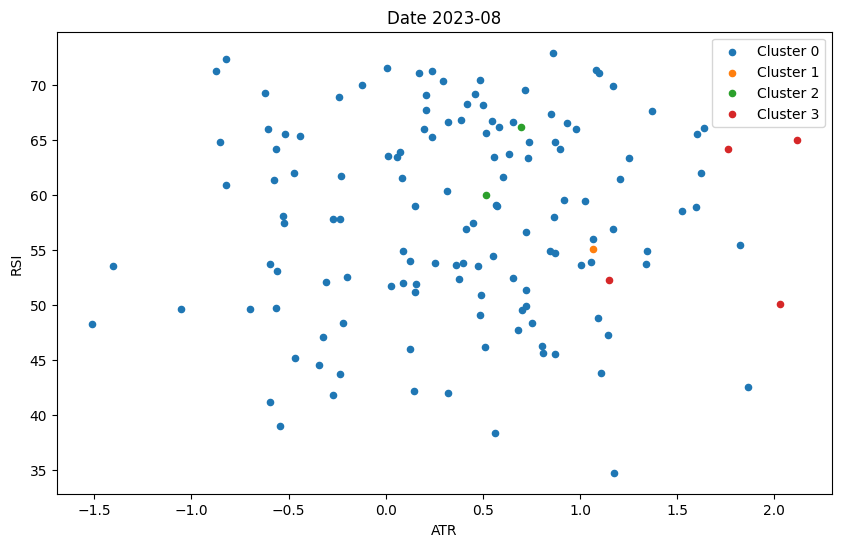

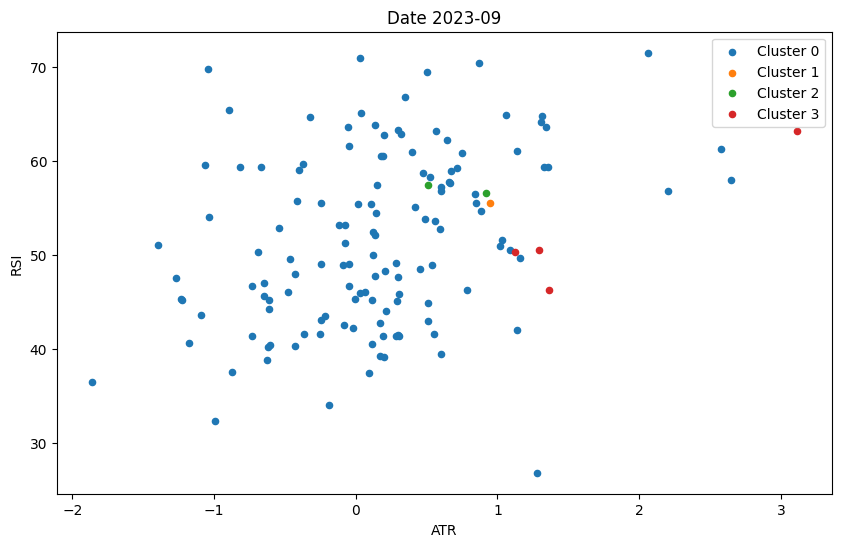

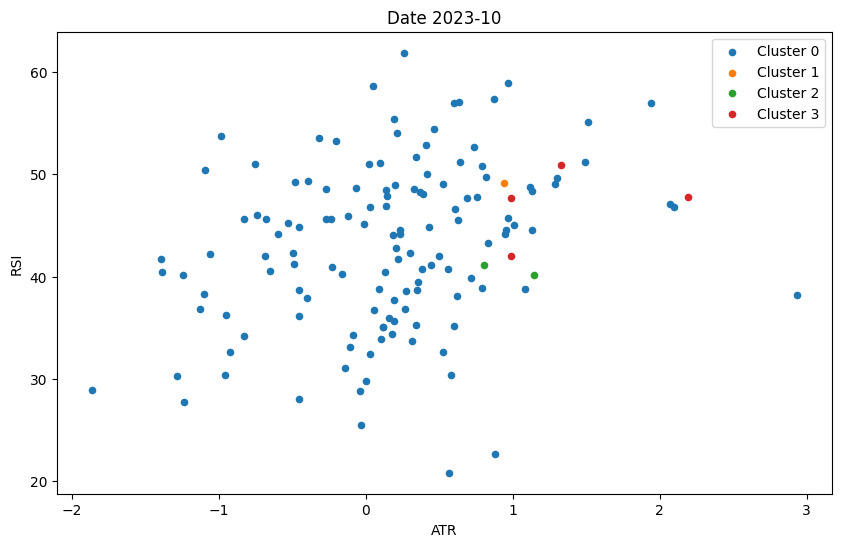

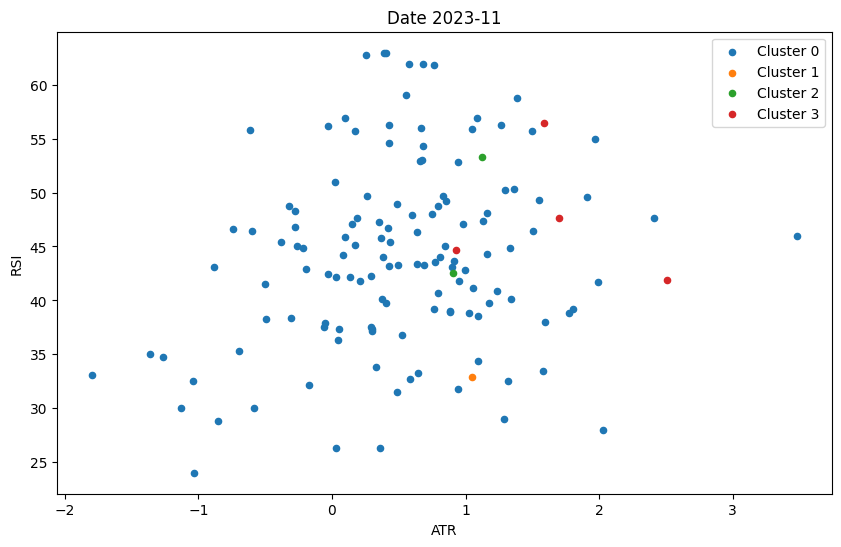

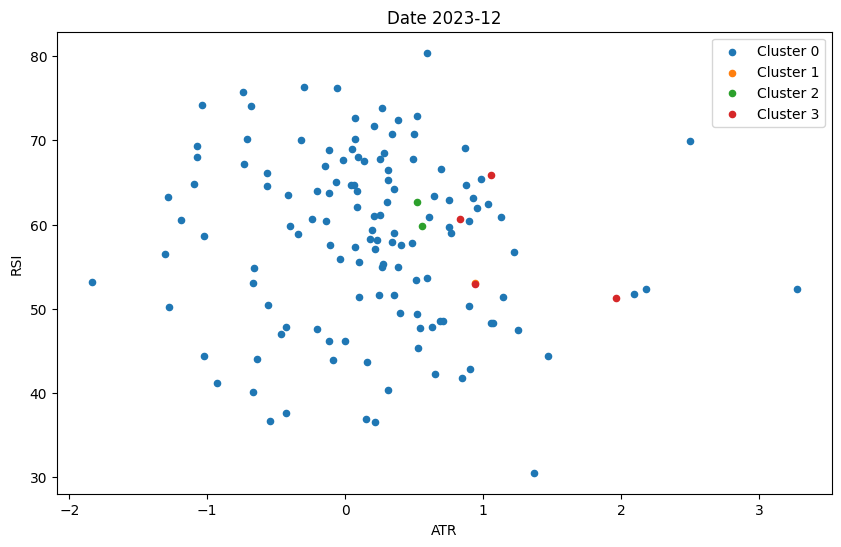

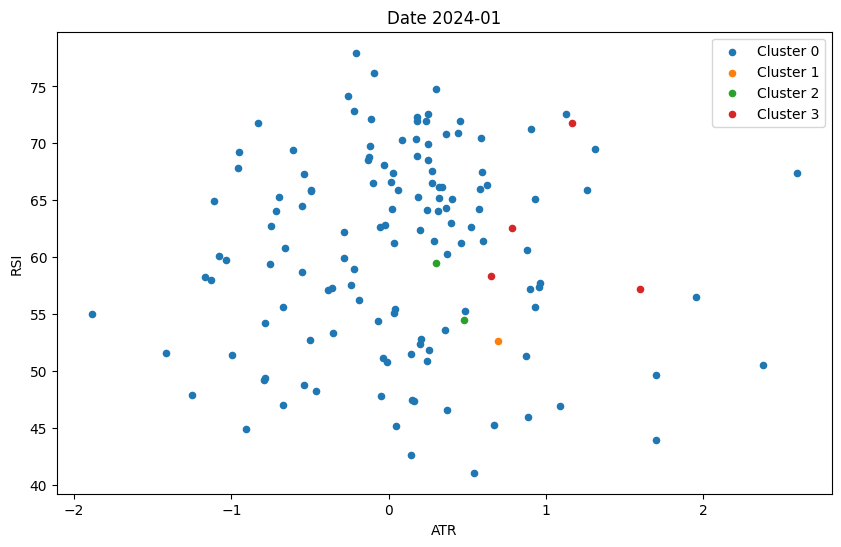

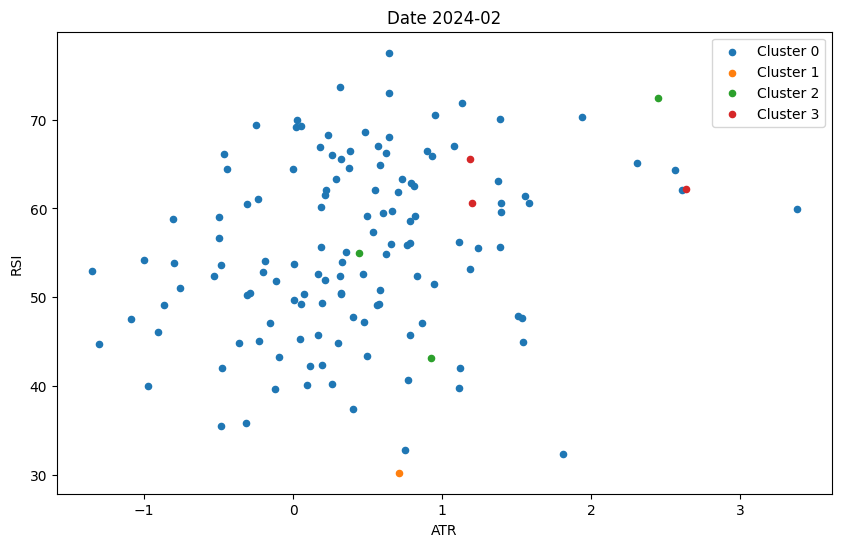

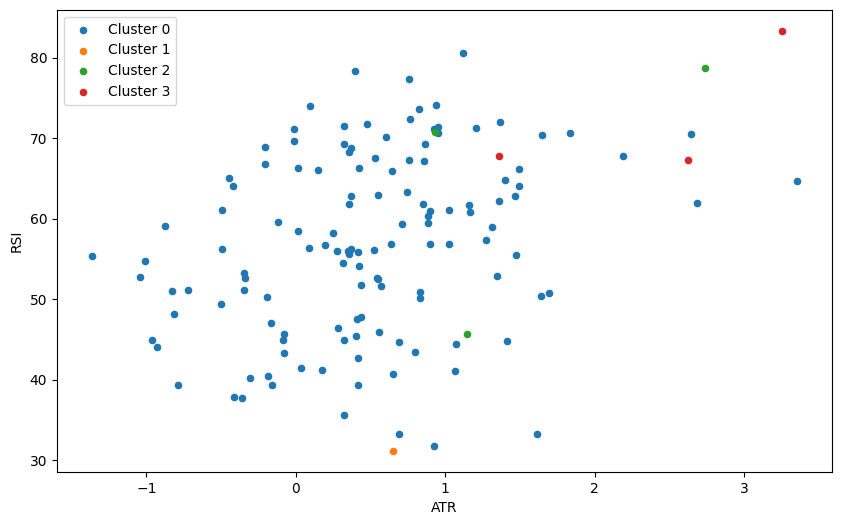

In [15]:
# Plot Clusters
# def plot_clusters(df):
#     cluster0 = df[df['Cluster']==0]
#     cluster1 = df[df['Cluster']==1]
#     cluster2 = df[df['Cluster']==2]
#     cluster3 = df[df['Cluster']==3]

#     plt.scatter(cluster0['ATR'], cluster0['RSI'], color='red', label='Cluster 0')
#     plt.scatter(cluster1['ATR'], cluster1['RSI'], color='green', label='Cluster 1')
#     plt.scatter(cluster2['ATR'], cluster2['RSI'], color='blue', label='Cluster 2')
#     plt.scatter(cluster3['ATR'], cluster3['RSI'], color='yellow', label='Cluster 3')
    
#     plt.legend()
#     plt.show()
#     return 


def plot_clusters(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, cluster in df.groupby('Cluster'):
        cluster.plot.scatter(x='ATR', y='RSI', ax=ax, label=f'Cluster {i}', color=f'C{i}')
    return

# plt.style.use('ggplot')

for i in data.index.get_level_values('Date').unique().tolist():
    cluster = data.xs(i, level='Date')
    plt.title(f'Date {i.strftime("%Y-%m")}')
    plt.legend()
    plt.show()
    plot_clusters(cluster)
    

    


In [17]:
# For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
filtered_df = data[data['Cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['Date', 'Symbol'])

dates = filtered_df.index.get_level_values('Date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2016-03-01': ['AMZN',
  'BAC',
  'BKNG',
  'GE',
  'GILD',
  'GOOG',
  'GOOGL',
  'MSFT',
  'NFLX',
  'TSLA'],
 '2016-04-01': ['AMZN',
  'BAC',
  'BKNG',
  'GE',
  'GILD',
  'GOOG',
  'GOOGL',
  'MSFT',
  'NFLX',
  'TSLA'],
 '2016-05-01': ['AMZN',
  'BAC',
  'BKNG',
  'GE',
  'GILD',
  'GOOG',
  'GOOGL',
  'MSFT',
  'NFLX',
  'TSLA'],
 '2016-06-01': ['AMZN',
  'BAC',
  'BKNG',
  'GE',
  'GILD',
  'GOOG',
  'GOOGL',
  'MSFT',
  'NFLX',
  'TSLA'],
 '2016-07-01': ['AMZN',
  'BAC',
  'BKNG',
  'GE',
  'GILD',
  'GOOG',
  'GOOGL',
  'MSFT',
  'NFLX',
  'TSLA'],
 '2016-08-01': ['AMZN',
  'BAC',
  'BKNG',
  'GE',
  'GILD',
  'GOOG',
  'GOOGL',
  'MSFT',
  'NFLX',
  'TSLA'],
 '2016-09-01': ['AMZN',
  'BAC',
  'BKNG',
  'GE',
  'GILD',
  'GOOG',
  'GOOGL',
  'MSFT',
  'NFLX',
  'TSLA'],
 '2016-10-01': ['AMZN',
  'BAC',
  'BKNG',
  'GE',
  'GILD',
  'GOOG',
  'GOOGL',
  'MSFT',
  'NFLX',
  'TSLA'],
 '2016-11-01': ['AMZN',
  'BAC',
  'BKNG',
  'GE',
  'GILD',
  'GOOG',
  'GOOGL',
  'MSFT',
  'N

In [20]:
# Define portfolio optimization function
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

# Fresh daily data for the selected stocks
stocks = data.index.get_level_values('Symbol').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('Date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('Date').unique()[-1])

new_df


[*********************100%%**********************]  169 of 169 completed


Adj Close                                                  \
                  AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2015-03-02  45.866634   29.002455   41.350346   39.823296   78.253265   
2015-03-03  46.303364   29.063118   40.775841   39.713661   77.961456   
2015-03-04  46.474266   28.878883   41.220390   39.646187   78.021530   
2015-03-05  45.952076   28.400349   38.888206   40.008827   78.999908   
2015-03-06  45.572311   28.443033   38.053806   39.216076   77.815575   
...               ...         ...         ...         ...         ...   
2024-01-29  14.940000  191.729996  163.910004  113.449997  373.350006   
2024-01-30  14.530000  188.039993  164.919998  113.480003  371.299988   
2024-01-31  14.230000  184.399994  164.399994  113.150002  363.880005   
2024-02-01  14.340000  186.860001  167.589996  114.489998  370.910004   
2024-02-02  14.560000  185.850006  168.669998  112.110001  372.950012   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2015-03-02   79.790001   74.152534   64.000000  44.582661   22.843401  ...   
2015-03-03   78.989998   72.935547   62.700001  44.526592   21.827354  ...   
2015-03-04   77.629997   71.192352   62.520000  44.366364   21.631273  ...   
2015-03-05   78.620003   71.332130   62.950001  44.550632   21.551054  ...   
2015-03-06   77.550003   70.715454   61.740002  44.863064   21.310413  ...   
...                ...         ...         ...        ...         ...  ...   
2024-01-29  630.229980  237.710007  257.230011  69.370003  168.479996  ...   
2024-01-30  627.960022  238.589996  256.470001  70.379997  166.240005  ...   
2024-01-31  617.780029  245.779999  253.809998  69.510002  164.300003  ...   
2024-02-01  627.909973  247.080002  255.070007  68.820000  166.970001  ...   
2024-02-02  634.760010  248.809998  256.450012  69.629997  168.179993  ...   

             Volume                                                            \
               VRTX      VTRS        VZ       WBA      WDC       WFC      WMT   
Date                                                                            
2015-03-02  1511200   3572800  10914400   6659700  1821100  12988500  6061500   
2015-03-03  1532500   6511100  11381400   5729900  1791500  11759600  6460800   
2015-03-04  1363200   3810100  13870600   3890500  1649500  16653300  6214400   
2015-03-05  2413700   4946800   9653500   3223600   881700   9576100  5997500   
2015-03-06  1581100   2302200  15644900   4714800  1509800  17298400  5731000   
...             ...       ...       ...       ...      ...       ...      ...   
2024-01-29  1004100   6216500  23905700  12197400  9380300  16725200  6080100   
2024-01-30  3329900   5619000  20044600  11689100  9717100  14736800  5090000   
2024-01-31  2755200  13432000  23392300  60298100  5798000  20394400  8711600   
2024-02-01  1484600   6760400  19586500  14326600  7272800  27566100  6930900   
2024-02-02  2181300   6441000  21546500  11315000  5529400  19329000  7218900   

                                         
               WYNN       XOM       YUM  
Date                                     
2015-03-02  1430800  13793700   4698103  
2015-03-03  2146500  13493800   6465924  
2015-03-04  2854000  13467600  10754238  
2015-03-05  2106100  12527600   4663328  
2015-03-06  2851600  16070500   5866682  
...             ...       ...       ...  
2024-01-29  1261800  18317500   1482100  
2024-01-30  1388400  19610900   1421500  
2024-01-31  1583000  22415300   2154200  
2024-02-01  1942200  19240700   1440700  
2024-02-02  1225200  21968200   1823800  

[2248 rows x 1014 columns]

In [22]:
# Calculate daily returns for each stock which could land up in our portfolio.
# Then loop over each month start, select the stocks for the month and calculate their weights for the next month.
# If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.
# Calculated each day portfolio return.

returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('Return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('Weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['Date', 'Symbol']

        temp_df['Weighted_Return'] = temp_df['Return']*temp_df['Weight']

        temp_df = temp_df.groupby(level=0)['Weighted_Return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2016-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-12-01, Continuing with Equal-Weights

,Strategy Return
Date,
2016-03-01,0.029395
2016-03-02,0.003359
2016-03-03,0.000432
2016-03-04,0.004876
2016-03-07,-0.011211
...,...
2024-01-29,0.014507
2024-01-30,-0.008302
2024-01-31,-0.024554


In [23]:
# Visualize Portfolio returns and compare to SP500 returns

spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
Date,,
2016-03-01,0.029395,0.023235
2016-03-02,0.003359,0.004482
2016-03-03,0.000432,0.003912
2016-03-04,0.004876,0.003248
2016-03-07,-0.011211,0.000798
...,...,...
2024-01-29,0.014507,0.007888
2024-01-30,-0.008302,-0.000774
2024-01-31,-0.024554,-0.016452


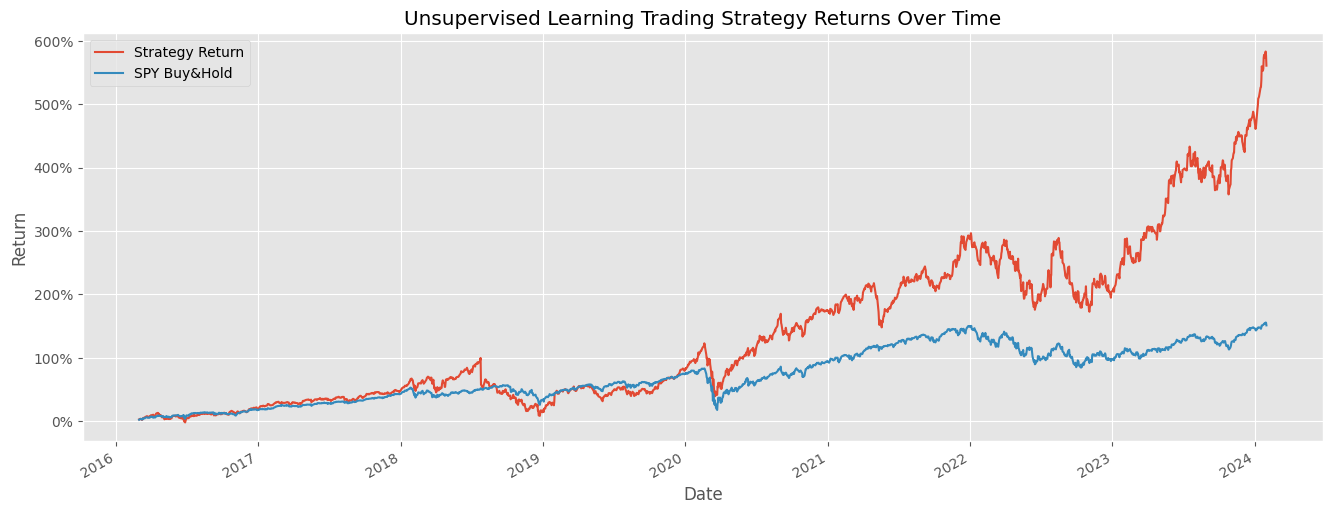

In [25]:
# Plkotting Strategy Returns over time
import matplotlib.ticker as mtick

plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulative_return[:'2024-01-31'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')

plt.show()